<h3 align="center"><font size="15">Projet 4 : Anticipez les besoins en consommation de bâtiments</font></h3>

# Sommaire

* <font size="4">[Chapitre 1 : Préparation des données](#chapter1)</font>
    * [Introduction](#section_1_1)
    * [Filtrage](#section_1_2)
        * [Importation des données](#section_1_2_1)
        * [Visualisation des données](#section_1_2_2)
        * [Filtres sur le type de bâtiments](#section_1_2_3)
        * [Filtre sur la conformité](#section_1_2_4)
    * [Renommage de certaines observables](#section_1_3)
        * [Quartiers](#section_1_3_1)
        * [Types de bâtiments](#section_1_3_2)
        * [Dimensions bâtiments](#section_1_3_3)
        * [Consommation des bâtiments](#section_1_3_4)
    * [Traitement des valeurs manquantes](#section_1_4)  

* <font size="4">[Chapitre 2 : Analyse des données](#chapter)</font>
    * [Analyse univariée](#section_2_1)
    * [Analyse bivariée](#section_2_2)
        * [Matrice de corrélation](#section_2_2_1)
        * [Consommation totale d'énergie](#section_2_2_2)
        * [Emission de CO<sub>2</sub>](#section_2_2_3)
    * [Analyse multivariée](#section_2_3)
        * [Fonctions et sélection des variables](#section_2_3_1)
        * [Analyse en composante principale](#section_2_3_2)
            * [Données bruts](#section_2_3_2_1)
            * [Filtres successifs](#section_2_3_2_2)
            * [Données finales](#section_2_3_2_2")

<a class="anchor" id="chapter1"></a>
# Chapitre 1 : Préparation des données

<a class="anchor" id="section_1_1"></a>
## Introduction du sujet 

Vous travaillez pour la ville de Seattle. **Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.**

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez **tenter de prédire les émissions de CO<sub>2</sub> et la consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.

Vous cherchez également à **évaluer l’intérêt de l’"ENERGY STAR Score"** pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

**Douglas** : **L’objectif est de te passer des relevés de consommation annuels futurs** (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

**Fais bien attention au traitement des différentes variables**, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et **optimiser les performances en appliquant des transformations simples aux variables** (normalisation, passage au log, etc.).

**Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.**


<a class="anchor" id="section_1_2"></a>
## Filtrage
<a class="anchor" id="section_1_2_1"></a>
### Importation des données

En premier lieu, nous allons importer les relevés. Ensuite, nous afficherons les différentes informations du fichier (doublons et données manquantes) puis nous garderons uniquement les données liées aux bâtiments non destinés à l'habitation.

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import scipy.stats as st
import random
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.collections import LineCollection
from matplotlib import colors
from itertools import chain
from matplotlib.lines import Line2D
import statsmodels.api as sm

data_building = pd.read_csv("2016_Building_Energy_Benchmarking.csv", low_memory=False)

Nous vérifions que les données sont bien importées en affichant le début ainsi qu'en regardant un bref aperçu du fichier à l'échelle globale. 

In [98]:
display(data_building.head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [99]:
data_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

<a class="anchor" id="section_1_2_2"></a>
### Visualisation des données

Après avoir importé les données, nous regardons les dimensions du dataframe importé ainsi que le nombre de doublons et le pourcentage de données manquantes.

In [100]:
display(f"Le relevé de données (data_building) contient {data_building.shape[0]} lignes et {data_building.shape[1]} colonnes")

'Le relevé de données (data_building) contient 3376 lignes et 46 colonnes'

In [101]:
display(f"Le relevé de données (data_building) contient {data_building.duplicated(keep=False).sum()} doublons")

'Le relevé de données (data_building) contient 0 doublons'

In [102]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
data_building["NAN"] = (data_building.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = data_building.shape[0]*data_building.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(data_building["NAN"].sum()*100/taile_data,2)
display(f"Il y a {data_missing} % de données manquantes")

'Il y a 12.57 % de données manquantes'

<a class="anchor" id="section_1_2_3"></a>
### Filtres sur le types de bâtiments

Comme indiqué dans la consigne, le projet porte sur la prédiction d'émission de CO<sub>2</sub> et de consommation totale d'énergie pour les bâtiments non destinés à l'habitation.
Nous allons étudier les variables catégorielles pouvant nous renseigner sur le type de bâtiments et conserver uniquement les bâtiments non destinés à l'habitation.

In [103]:
display(data_building["BuildingType"].value_counts().sort_index())

Campus                    24
Multifamily HR (10+)     110
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
NonResidential          1460
Nonresidential COS        85
Nonresidential WA          1
SPS-District K-12         98
Name: BuildingType, dtype: int64

In [104]:
display(data_building["LargestPropertyUseType"].value_counts().sort_index())

Adult Education                                            2
Automobile Dealership                                      5
Bank Branch                                                4
College/University                                        25
Convention Center                                          1
Courthouse                                                 1
Data Center                                                3
Distribution Center                                       54
Financial Office                                           4
Fire Station                                               1
Fitness Center/Health Club/Gym                             5
Food Service                                               1
Hospital (General Medical & Surgical)                     10
Hotel                                                     77
K-12 School                                              139
Laboratory                                                13
Library                 

In [105]:
display(data_building["SecondLargestPropertyUseType"].value_counts().sort_index())

Adult Education                                           2
Automobile Dealership                                     2
Bank Branch                                               7
Bar/Nightclub                                             3
College/University                                        1
Convenience Store without Gas Station                     1
Courthouse                                                1
Data Center                                              13
Distribution Center                                       7
Enclosed Mall                                             1
Financial Office                                          2
Fitness Center/Health Club/Gym                           17
Food Sales                                                3
Food Service                                              4
Hospital (General Medical & Surgical)                     2
Hotel                                                     3
K-12 School                             

In [106]:
display(data_building["ThirdLargestPropertyUseType"].value_counts().sort_index())

Bank Branch                                               6
Bar/Nightclub                                             3
College/University                                        1
Convenience Store without Gas Station                     2
Data Center                                              14
Distribution Center                                       3
Fast Food Restaurant                                      3
Financial Office                                          5
Fitness Center/Health Club/Gym                            6
Food Sales                                                3
Food Service                                             11
Hotel                                                     1
K-12 School                                               2
Laboratory                                                2
Manufacturing/Industrial Plant                            1
Medical Office                                           17
Multifamily Housing                     

Nous pouvons déduire des différentes occurences présentes dans certaines variables catégorielles qu'il y a des bâtiments déstinés à l'habitation via l'expression "Multifamily...". Donc nous créeons un dataframe en excluant ce type de bâtiments.

In [107]:
building_no_house = data_building.loc[(data_building["BuildingType"]!="Multifamily LR (1-4)") & 
                             (data_building["BuildingType"]!="Multifamily MR (5-9)") & 
                             (data_building["BuildingType"]!="Multifamily HR (10+)"),:]
building_no_house = building_no_house.loc[
    (building_no_house["LargestPropertyUseType"]!="Multifamily Housing") & 
    (building_no_house["SecondLargestPropertyUseType"]!="Multifamily Housing") &
    (building_no_house["ThirdLargestPropertyUseType"]!="Multifamily Housing") &
    building_no_house["LargestPropertyUseType"].notnull(),:]
display(building_no_house.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1626 entries, 0 to 3375
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1626 non-null   int64  
 1   DataYear                         1626 non-null   int64  
 2   BuildingType                     1626 non-null   object 
 3   PrimaryPropertyType              1626 non-null   object 
 4   PropertyName                     1626 non-null   object 
 5   Address                          1626 non-null   object 
 6   City                             1626 non-null   object 
 7   State                            1626 non-null   object 
 8   ZipCode                          1610 non-null   float64
 9   TaxParcelIdentificationNumber    1626 non-null   object 
 10  CouncilDistrictCode              1626 non-null   int64  
 11  Neighborhood                     1626 non-null   object 
 12  Latitude            

None

<a class="anchor" id="section_1_2_4"></a>
### Filtre sur la conformité

Nous regardons maintenant si les données sur les bâtiments sont exploitables. Nous nous basons sur certaines variables liées à la consommation.  

In [108]:
display(building_no_house.iloc[:,29:40].min())

SiteEUI(kBtu/sf)              0.00000
SiteEUIWN(kBtu/sf)            0.00000
SourceEUI(kBtu/sf)            0.00000
SourceEUIWN(kBtu/sf)         -2.10000
SiteEnergyUse(kBtu)           0.00000
SiteEnergyUseWN(kBtu)         0.00000
SteamUse(kBtu)                0.00000
Electricity(kWh)         -33826.80078
Electricity(kBtu)       -115417.00000
NaturalGas(therms)            0.00000
NaturalGas(kBtu)              0.00000
dtype: float64

Certaines valeurs de consommation sont nulles (et même négatives) ce qui semble indiquer que le(s) bâtiment(s) ne sont pas alimenté(s) et/ou non utilisé(s) ou qu'il y a un autre problème.
Nous regardons alors les bâtiments où ces valeurs sont nulles et aussi leur états de conformités.

In [109]:
display(building_no_house.loc[building_no_house["SiteEUI(kBtu/sf)"]<=0].iloc[:,0:10])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber
28,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090
31,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.0,0809000005
62,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,3701 S.W. 104th St.,Seattle,WA,98146.0,2518400005
81,118,2016,SPS-District K-12,K-12 School,Pathfinder K-8,1901 SW Genesee St.,Seattle,WA,98106.0,1324039116
85,122,2016,SPS-District K-12,K-12 School,John Muir Elementary,3301 S. Horton St.,Seattle,WA,98144.0,1524049002
95,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,3921 Linden Ave. N.,Seattle,WA,98103.0,1931301145
133,217,2016,SPS-District K-12,K-12 School,Whitman Middle,9201 15th Ave. NW.,Seattle,WA,98117.0,3526039131
139,227,2016,SPS-District K-12,K-12 School,Washington Middle,2101 S. Jackson,Seattle,WA,98144.0,3646100540
152,242,2016,SPS-District K-12,K-12 School,Olympic View Elementary,504 N.E. 95th St.,Seattle,WA,98115.0,5100404840
614,820,2016,SPS-District K-12,K-12 School,Bailey Gatzert Elementary,1301 E. Yesler Way,Seattle,WA,98122.0,0007600137


In [110]:
display(building_no_house.loc[building_no_house["SiteEUI(kBtu/sf)"]<=0].iloc[:,10:20])

,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)
28,3,Central,47.62266,-122.30547,1955,1.0,1,126351,0,126351
31,7,MAGNOLIA / QUEEN ANNE,47.63290,-122.35172,1989,1.0,2,51582,0,51582
62,1,SOUTHWEST,47.50970,-122.37759,1948,1.0,2,53352,0,53352
81,1,DELRIDGE,47.56360,-122.35800,1999,1.0,3,74468,0,74468
85,2,SOUTHEAST,47.57324,-122.29058,1991,1.0,2,58933,0,58933
95,6,LAKE UNION,47.65464,-122.34912,1991,1.0,3,66588,0,66588
133,6,BALLARD,47.69675,-122.37760,1959,1.0,1,160270,0,160270
139,3,CENTRAL,47.59796,-122.30415,1963,1.0,3,136188,0,136188
152,5,NORTH,47.69823,-122.32126,1989,1.0,2,52792,0,52792
614,3,CENTRAL,47.60120,-122.31548,1988,1.0,1,52924,0,52924


In [111]:
display(building_no_house.loc[building_no_house["SiteEUI(kBtu/sf)"]<=0].iloc[:,20:30])

,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf)
28,K-12 School,K-12 School,126351.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
31,K-12 School,K-12 School,55166.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
62,K-12 School,K-12 School,65568.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
81,K-12 School,K-12 School,75364.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
85,K-12 School,K-12 School,60725.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
95,K-12 School,K-12 School,66588.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
133,K-12 School,K-12 School,160270.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
139,K-12 School,K-12 School,136188.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
152,K-12 School,K-12 School,55480.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
614,K-12 School,K-12 School,52924.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [112]:
display(building_no_house.loc[building_no_house["SiteEUI(kBtu/sf)"]<=0].iloc[:,30:40])

,SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu)
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,438691.6875,1496816.0,0.000000,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,176088.0938,600813.0,0.000000,0.0
81,0.0,0.0,0.0,0.0,0.0,0.0,497706.8125,1698176.0,0.000000,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,687906.8750,2347138.0,0.000000,0.0
95,0.0,0.0,0.0,0.0,0.0,0.0,616730.8125,2104286.0,0.000000,0.0
133,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,43189.171880,4318917.0
139,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,32178.773440,3217877.0
152,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0
614,0.0,0.0,0.0,0.0,0.0,0.0,573642.5000,1957268.0,0.000000,0.0


In [113]:
display(building_no_house.loc[building_no_house["SiteEUI(kBtu/sf)"]<=0].iloc[:,40:])

,DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NAN
28,False,NaN,Missing Data,NaN,0.00,0.00,8
31,False,NaN,Missing Data,NaN,10.43,0.20,8
62,False,NaN,Missing Data,NaN,4.19,0.08,8
81,False,NaN,Missing Data,NaN,11.84,0.16,8
85,False,NaN,Missing Data,NaN,16.36,0.28,8
95,False,NaN,Missing Data,NaN,14.67,0.22,8
133,False,NaN,Missing Data,NaN,229.38,1.43,8
139,False,NaN,Missing Data,NaN,170.90,1.25,8
152,False,NaN,Missing Data,NaN,0.00,0.00,8
614,False,NaN,Missing Data,NaN,13.64,0.26,8


Nous notons qu'il y a plusieurs bâtiments où les données en consommation sont nulles. De plus, il est stipulé dans l'état de conformité que les données sur ces bâtiments sont manquantes ou que ce sont les données par défaut.

Nous supprimons alors les bâtiments où les données sont manquantes pour éviter de fausser la modélisation.

In [114]:
display(building_no_house["ComplianceStatus"].value_counts())

Compliant                       1509
Error - Correct Default Data      88
Non-Compliant                     15
Missing Data                      14
Name: ComplianceStatus, dtype: int64

In [115]:
display(building_no_house.loc[building_no_house["ComplianceStatus"]=="Missing Data"].iloc[:,29:40])

,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu)
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,438691.6875,1496816.0,0.000000,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176088.0938,600813.0,0.000000,0.0
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,497706.8125,1698176.0,0.000000,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,687906.8750,2347138.0,0.000000,0.0
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,616730.8125,2104286.0,0.000000,0.0
133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,43189.171880,4318917.0
139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,32178.773440,3217877.0
152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0
614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,573642.5000,1957268.0,0.000000,0.0


In [116]:
building_no_house = building_no_house.loc[building_no_house["ComplianceStatus"]!="Missing Data",:].reset_index(drop=True)
display(building_no_house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612 entries, 0 to 1611
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1612 non-null   int64  
 1   DataYear                         1612 non-null   int64  
 2   BuildingType                     1612 non-null   object 
 3   PrimaryPropertyType              1612 non-null   object 
 4   PropertyName                     1612 non-null   object 
 5   Address                          1612 non-null   object 
 6   City                             1612 non-null   object 
 7   State                            1612 non-null   object 
 8   ZipCode                          1596 non-null   float64
 9   TaxParcelIdentificationNumber    1612 non-null   object 
 10  CouncilDistrictCode              1612 non-null   int64  
 11  Neighborhood                     1612 non-null   object 
 12  Latitude            

None

<a class="anchor" id="section_1_3"></a>
## Renommage de certaines observables
<a class="anchor" id="section_1_3_1"></a>
### Quartiers
Avant de traiter les valeurs manquantes, nous allons renommer quelques valeurs catégorielles. Nous commencons par la variable "Neighborhood".

In [117]:
display(building_no_house["Neighborhood"].value_counts().sort_index())

BALLARD                    59
Ballard                     6
CENTRAL                    48
Central                     3
DELRIDGE                   41
DELRIDGE NEIGHBORHOODS      1
DOWNTOWN                  342
Delridge                    4
EAST                      116
GREATER DUWAMISH          343
LAKE UNION                141
MAGNOLIA / QUEEN ANNE     148
NORTH                      57
NORTHEAST                 124
NORTHWEST                  80
North                       9
Northwest                   5
SOUTHEAST                  45
SOUTHWEST                  40
Name: Neighborhood, dtype: int64

Nous voyons assez facilement que certains noms de quartier sont identiques mais diffèrent uniquement pas la casse. Nous homogénéisons l'ensemble des quartiers. Nous regardons aussi s'il est possible de regrouper certains noms de quartiers entre eux si besoin pour la modélisation.

In [118]:
building_no_house.loc[building_no_house["Neighborhood"]=="North","Neighborhood"]="NORTH"
building_no_house.loc[building_no_house["Neighborhood"]=="Central","Neighborhood"]="CENTRAL"
building_no_house.loc[building_no_house["Neighborhood"]=="Northwest","Neighborhood"]="NORTHWEST"
building_no_house.loc[building_no_house["Neighborhood"]=="Ballard","Neighborhood"]="BALLARD"
building_no_house.loc[building_no_house["Neighborhood"]=="Delridge","Neighborhood"]="DELRIDGE"
building_no_house.loc[building_no_house["Neighborhood"]=="DELRIDGE NEIGHBORHOODS",
                      "Neighborhood"]="DELRIDGE"

In [119]:
display(building_no_house["Neighborhood"].value_counts().sort_index())

BALLARD                   65
CENTRAL                   51
DELRIDGE                  46
DOWNTOWN                 342
EAST                     116
GREATER DUWAMISH         343
LAKE UNION               141
MAGNOLIA / QUEEN ANNE    148
NORTH                     66
NORTHEAST                124
NORTHWEST                 85
SOUTHEAST                 45
SOUTHWEST                 40
Name: Neighborhood, dtype: int64

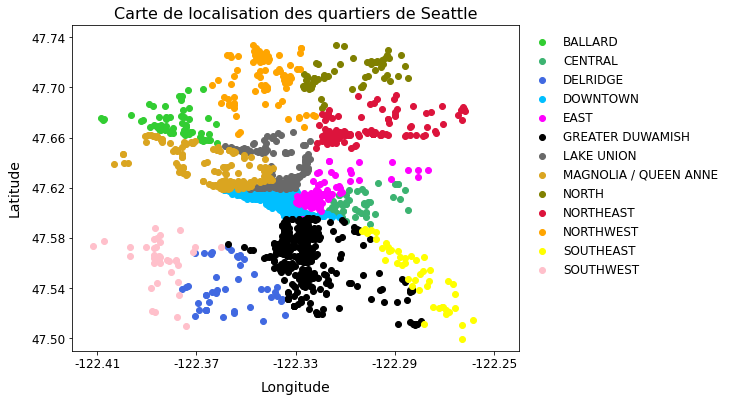

In [120]:
from matplotlib.ticker import StrMethodFormatter

# Nous créeons la liste des quartiers
liste_quart = sorted(building_no_house["Neighborhood"].unique().tolist())

# Nous créeons une liste de couleurs pour distinguer chaque quartier
couleurs = ["limegreen","mediumseagreen", "royalblue","deepskyblue","magenta", "black", "dimgrey","goldenrod","olive",
          "crimson","orange","yellow","pink"]

# Nous traçons la carte de la ville en nous aidant de la latitude et de la longitude 
# de chaque bâtiments

plt.figure(figsize=(8,6))
for i in range(0,13):
    X = []
    Y = []
    X = building_no_house.loc[building_no_house["Neighborhood"]==liste_quart[i],"Longitude"].tolist()
    Y = building_no_house.loc[building_no_house["Neighborhood"]==liste_quart[i],"Latitude"].tolist()
    plt.scatter(X,Y,marker="o", label=liste_quart[i],color=couleurs[i])

plt.xlabel("Longitude",fontsize=14,labelpad=10)
plt.ylabel("Latitude",fontsize=14,labelpad=10)

plt.xticks([-122.41,-122.37,-122.33,-122.29,-122.25],fontsize=12)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

plt.yticks([47.50,47.54,47.58,47.62,47.66,47.70,47.74],fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

plt.xlim(-122.42,-122.24)
plt.ylim(47.49,47.75)

plt.title("Carte de localisation des quartiers de Seattle", fontsize=16)

plt.legend(frameon=False, bbox_to_anchor=(1,1),fontsize=12)

plt.show()

A travers la carte représentant la localisation de chaque quartier, nous pouvons séparer les quartiers en 3 catégories :
- Sud (SOUTHWEST, SOUTHEAST, DELRIDGE, GREATER DUWAMISH)
- Centre (DOWNTOWN, CENTRAL, EAST, LAKE UNION, MAGNOLIA/QUEEN ANNE )
- Nord (BALLARD, NORTHWEST, NORTH, NORTHEAST)

Nous créeons une nouvelle variable "Quartier_compact"

In [121]:
liste_sud = ["SOUTHWEST", "SOUTHEAST", "DELRIDGE", "GREATER DUWAMISH"]
liste_centre = ["DOWNTOWN", "LAKE UNION", "MAGNOLIA / QUEEN ANNE", "CENTRAL", "EAST"]
liste_nord = ["BALLARD", "NORTHWEST", "NORTHEAST", "NORTH"]

for elt in liste_sud:
    building_no_house.loc[building_no_house["Neighborhood"]==elt,"Quartier_compact"] = "Sud"

for elt in liste_centre:
    building_no_house.loc[building_no_house["Neighborhood"]==elt,"Quartier_compact"] = "Centre"
    
for elt in liste_nord:
    building_no_house.loc[building_no_house["Neighborhood"]==elt,"Quartier_compact"] = "Nord"

In [122]:
display(building_no_house["Quartier_compact"].value_counts())

Centre    798
Sud       474
Nord      340
Name: Quartier_compact, dtype: int64

<a class="anchor" id="section_1_3_2"></a>
### Types de bâtiments
Nous allons regarder les variables "BuildingType" et "PrimaryPropertyType" et s'il y a des potentiels groupes faisables.

In [123]:
display(building_no_house["BuildingType"].value_counts().sort_index())

Campus                  22
NonResidential        1419
Nonresidential COS      85
Nonresidential WA        1
SPS-District K-12       85
Name: BuildingType, dtype: int64

In [124]:
display(building_no_house["PrimaryPropertyType"].value_counts())

Small- and Mid-Sized Office    285
Other                          248
Warehouse                      187
Large Office                   170
K-12 School                    126
Retail Store                    91
Mixed Use Property              89
Hotel                           75
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           27
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [125]:
building_no_house.loc[building_no_house["BuildingType"]=="Campus",
                      "PrimaryPropertyType"].value_counts().sort_index()

K-12 School           4
Large Office          1
Mixed Use Property    3
Other                 7
Restaurant            1
University            6
Name: PrimaryPropertyType, dtype: int64

In [126]:
building_no_house.loc[building_no_house["BuildingType"]=="NonResidential",
                      "PrimaryPropertyType"].value_counts().sort_index()

Distribution Center             51
Hospital                        10
Hotel                           75
K-12 School                     39
Laboratory                      10
Large Office                   165
Medical Office                  38
Mixed Use Property              78
Other                          183
Refrigerated Warehouse          12
Residence Hall                  21
Restaurant                      10
Retail Store                    91
Self-Storage Facility           27
Senior Care Community           20
Small- and Mid-Sized Office    281
Supermarket / Grocery Store     40
University                      17
Warehouse                      180
Worship Facility                71
Name: PrimaryPropertyType, dtype: int64

In [127]:
building_no_house.loc[building_no_house["BuildingType"]=="Nonresidential COS",
                      "PrimaryPropertyType"].value_counts().sort_index()

Distribution Center             2
Large Office                    4
Medical Office                  1
Mixed Use Property              8
Office                          3
Other                          56
Small- and Mid-Sized Office     4
Warehouse                       7
Name: PrimaryPropertyType, dtype: int64

In [128]:
building_no_house.loc[building_no_house["BuildingType"]=="Nonresidential WA",
                      "PrimaryPropertyType"].value_counts().sort_index()

University    1
Name: PrimaryPropertyType, dtype: int64

In [129]:
building_no_house.loc[building_no_house["BuildingType"]=="SPS-District K-12",
                      "PrimaryPropertyType"].value_counts()

K-12 School    83
Other           2
Name: PrimaryPropertyType, dtype: int64

Nous pouvons observer qu'il y a peu de catégories pour la variable "BuildingType" dont une catégorie avec une seule occurence.
En revanche, selon chacune de ces catégories nous retrouvons plusieurs occurences de la variable "PrimaryPropertyType", dont certaines redondantes.
Nous allons créer une nouvelle variable qui condenserait la classification des catégories de la variable "PrimaryPropertyType". Typiquement, nous pourrions créer les catégories suivantes : 
- Ecole (K-12 School, University, Residence Hall)
- Entrepôt (Distribution Center, Refrigerated Warehouse, Retail Store, Self-Storage Facility, Supermarket / Grocery Store, Warehouse)
- Science (Hospital, Laboratory, Medical Office, Senior Care Community)
- Bureau (Large Office, Office, Small- and Mid-Sized Office)
- Autre (Hotel, Mixed Use Property, Other, Restaurant, Worship Facility)

Comme précédemment, nous créeons une nouvelle variable appelé cette fois-ci "Usage_bâtiments"

In [130]:
liste_ecole = ["K-12 School", "University", "Residence Hall"]
liste_entrepot = ["Distribution Center", "Refrigerated Warehouse", "Retail Store", 
                  "Self-Storage Facility", "Supermarket / Grocery Store", "Warehouse"]
liste_science = ["Hospital", "Laboratory", "Medical Office", "Senior Care Community"]
liste_bureau = ["Large Office", "Office", "Small- and Mid-Sized Office"]
liste_autre = ["Hotel", "Mixed Use Property", "Other", "Restaurant", "Worship Facility"]


for elt in liste_ecole:
    building_no_house.loc[building_no_house["PrimaryPropertyType"]==elt,
                          "Usage_bâtiments"] = "Ecoles"

for elt in liste_entrepot:
    building_no_house.loc[building_no_house["PrimaryPropertyType"]==elt,
                          "Usage_bâtiments"] = "Entrepôts"
    
for elt in liste_science:
    building_no_house.loc[building_no_house["PrimaryPropertyType"]==elt,
                          "Usage_bâtiments"] = "Sciences"
    
for elt in liste_bureau:
    building_no_house.loc[building_no_house["PrimaryPropertyType"]==elt,
                          "Usage_bâtiments"] = "Bureaux"
    
for elt in liste_autre:
    building_no_house.loc[building_no_house["PrimaryPropertyType"]==elt,
                          "Usage_bâtiments"] = "Autres"

In [131]:
display(building_no_house["Usage_bâtiments"].value_counts())

Autres       494
Bureaux      458
Entrepôts    410
Ecoles       171
Sciences      79
Name: Usage_bâtiments, dtype: int64

Nous regardons les différentes catégories pour la variable "LargestPropertyUseType"

In [132]:
display(building_no_house["LargestPropertyUseType"].value_counts().sort_index())

Adult Education                                           2
Automobile Dealership                                     5
Bank Branch                                               4
College/University                                       24
Convention Center                                         1
Courthouse                                                1
Data Center                                               3
Distribution Center                                      54
Financial Office                                          4
Fire Station                                              1
Fitness Center/Health Club/Gym                            5
Food Service                                              1
Hospital (General Medical & Surgical)                    10
Hotel                                                    75
K-12 School                                             126
Laboratory                                               13
Library                                 

Etant donné qu'il y a beaucoup de catégorie pour cette variable, nous n'allons pas faire de transformation de variable.

Nous allons regarder la variable "ListOfAllPropertyUseTypes" qui énumère le nombre d'utilisations différentes pour chaque bâtiment.

In [133]:
building_no_house["ListOfAllPropertyUseTypes"].value_counts()

Office                                                                                                    137
K-12 School                                                                                               122
Office, Parking                                                                                           120
Non-Refrigerated Warehouse                                                                                101
Non-Refrigerated Warehouse, Office                                                                         61
                                                                                                         ... 
Lifestyle Center                                                                                            1
Personal Services (Health/Beauty, Dry Cleaning, etc), Retail Store, Supermarket/Grocery Store               1
Non-Refrigerated Warehouse, Office, Other, Other - Recreation, Other - Services, Restaurant                 1
Adult Educ

Pour déterminer le nombre d'usage de chaque bâtiment ou site, nous allons transformer chaque ligne , qui est considéré comme 1 seul élément, en une liste d'usages. Pour cela nous allons séparer chaque usage via la méthode split et nous ferons cette séparation par les virgules.

Avant cela, il faut faire attention au contenu se trouvant entre parenthèses. Par exemple, les services personnels qui sont notés comme suit : "Personal Services (Health/Beauty, Dry Cleaning, etc)". 

Si nous faisons une séparation par virgule, alors les services personnels compteront pour 3 usages au lieu d'un seul. Nous allons d'abord vérifier s'il y a d'autres cas de figure similaire en recherchant l'ensemble des textes entre parenthèses. 

In [134]:
text = building_no_house[building_no_house["ListOfAllPropertyUseTypes"].str.contains(r"\((.*?)\)")].iloc[:,20].tolist()
display(text)

C:\Users\farid\AppData\Local\Temp\ipykernel_6460\438929012.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  text = building_no_house[building_no_house["ListOfAllPropertyUseTypes"].str.contains(r"\((.*?)\)")].iloc[:,20].tolist()


['Other - Mall, Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Hospital (General Medical & Surgical), Parking',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Hospital (General Medical & Surgical)',
 'Hospital (General Medical & Surgical), Parking',
 'Hospital (General Medical & Surgical), Parking',
 'Convenience Store without Gas Station, Data Center, Financial Office, Fitness Center/Health Club/Gym, Office, Other, Parking, Personal Services (Health/Beauty, Dry Cleaning, etc), Restaurant',
 'Office, Parking, Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Hospital (General Medical & Surgical)',
 'Personal Services (Health/Beauty, Dry Cleaning, etc), Retail Store, Supermarket/Grocery Store',
 'Bar/Nightclub, Office, Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Hospital (General Medical & Surgical), Parking',
 'Data Center, Non-Refrigerated Warehouse, Other, Refrigerated Warehouse, Repair Services (Vehicle, Shoe, Locksmith, etc), Restaurant',
 'Offi

Nous pouvons voir qu'il y a deux éléments à modifier, en l'occurence les services personnels et les services de réparation. Nous allons modifier les virgules par des "&".

In [135]:
building_no_house["ListOfAllPropertyUseTypes"] = building_no_house["ListOfAllPropertyUseTypes"].str.replace("Health/Beauty, Dry Cleaning, etc", 
                                                                                                            "Health/Beauty & Dry Cleaning & etc", regex=True)
building_no_house["ListOfAllPropertyUseTypes"] = building_no_house["ListOfAllPropertyUseTypes"].str.replace("Vehicle, Shoe, Locksmith, etc",
                                                                                                            "Vehicle & Shoe & Locksmith & etc", regex=True)

In [136]:
# Nous séparons chaque usage de telle sorte à avoir une liste d'usage pour chaque bâtiment. 
building_no_house["Liste_usage"] = (building_no_house["ListOfAllPropertyUseTypes"].str.split(","))

# Nous déterminons le nombre d'usage en déterminant la longueur liste de chaque liste.
building_no_house["Nbr_activités"] = building_no_house["Liste_usage"].str.len()

<a class="anchor" id="section_1_3_3"></a>
### Dimension des bâtiments

Nous allons nous concentrer sur les propriétés des bâtiments et plus précisément sur le nombre d'étages des bâtiments, le nombre de bâtiments, leur surface totale et les surfaces pour chaque usage.

Avec ces informations nous pouvons en déduire la hauteur des bâtiments, la surface unitaire et le pourcentage d'occupation du/des bâtiment(s) pour chaque usage.  

In [137]:
display(building_no_house["NumberofBuildings"].value_counts().sort_index())

0.0        50
1.0      1512
2.0        13
3.0        11
4.0         4
5.0         7
6.0         4
7.0         1
8.0         2
9.0         1
10.0        1
11.0        1
14.0        2
23.0        1
27.0        1
111.0       1
Name: NumberofBuildings, dtype: int64

In [138]:
display(building_no_house["NumberofFloors"].value_counts().sort_index())

0      15
1     458
2     381
3     254
4     137
5      99
6      81
7      33
8      21
9       8
10     18
11     17
12      9
13      5
14      9
15      6
16      3
17      4
18      3
19      4
20      3
21      3
22      3
23      3
24      3
25      3
27      1
28      1
29      3
30      1
33      3
34      2
36      2
37      1
41      2
42      5
46      1
47      1
49      1
55      1
56      1
63      1
76      1
99      1
Name: NumberofFloors, dtype: int64

Nous pouvons déduire la hauteur et la surface unitaire des bâtiments du nombre d'étages, du nombre de bâtiments et de la surface totale.

En revanche, il est à noter qu'il y a certains bâtiments où il y a 0 bâtiments ou 0 étages. Nous allons d'abord ajouter 1 à chaque ligne de ces deux variables, puis nous allons pouvoir déterminer la hauteur et la surface unitaire

In [139]:
building_no_house["NumberofBuildings"] +=1 
building_no_house["NumberofFloors"] +=1 

building_no_house["Hauteur"] =  building_no_house["NumberofFloors"]/building_no_house["NumberofBuildings"]
building_no_house["Surf_uni"] =  building_no_house["PropertyGFATotal"]/building_no_house["Hauteur"]

Ensuite nous allons déterminer le pourcentage d'occupation de chaque bâtiment. Avant cela, nous allons remplir les valeurs manquantes des variables "SecondLargestPropertyUseTypeGFA" et "ThirdLargestPropertyUseTypeGFA" par 0. 

In [140]:
building_no_house.loc[building_no_house["SecondLargestPropertyUseTypeGFA"].isna(),
                      "SecondLargestPropertyUseTypeGFA"] = 0
building_no_house.loc[building_no_house["ThirdLargestPropertyUseTypeGFA"].isna(),
                      "ThirdLargestPropertyUseTypeGFA"] = 0
building_no_house["Surface"] = np.nan
building_no_house["Surface"] = building_no_house["LargestPropertyUseTypeGFA"] 
building_no_house["Surface"] += building_no_house["SecondLargestPropertyUseTypeGFA"] 
building_no_house["Surface"] += building_no_house["ThirdLargestPropertyUseTypeGFA"]

building_no_house["%_occ_1st"] = building_no_house["LargestPropertyUseTypeGFA"]*100/building_no_house["Surface"]
building_no_house["%_occ_2nd"] = building_no_house["SecondLargestPropertyUseTypeGFA"]*100/building_no_house["Surface"]
building_no_house["%_occ_3rd"] = building_no_house["ThirdLargestPropertyUseTypeGFA"]*100/building_no_house["Surface"]

<a class="anchor" id="section_1_3_4"></a>
### Consommation des bâtiments
Enfin, nous allons déterminer quel type d'énergie est utilisé par chaque bâtiment.
Pour cela, nous regardons quels sont les bâtiments ayant une consommation en électricité non nulle et/ou en eau non nulle et/ou  en gaz naturels non nulle.

In [141]:
building_no_house.loc[(building_no_house["Electricity(kBtu)"]!=0) & 
                      (building_no_house["SteamUse(kBtu)"]!=0) &
                      (building_no_house["NaturalGas(kBtu)"]!=0), "Source_energie"] = "Elec_Eau_Gaz"

building_no_house.loc[(building_no_house["Electricity(kBtu)"]!=0) & 
                      (building_no_house["SteamUse(kBtu)"]!=0) &
                      (building_no_house["NaturalGas(kBtu)"]==0), "Source_energie"] = "Elec_Eau"

building_no_house.loc[(building_no_house["Electricity(kBtu)"]!=0) & 
                      (building_no_house["SteamUse(kBtu)"]==0) &
                      (building_no_house["NaturalGas(kBtu)"]!=0), "Source_energie"] = "Elec_Gaz"

building_no_house.loc[(building_no_house["Electricity(kBtu)"]==0) & 
                      (building_no_house["SteamUse(kBtu)"]!=0) &
                      (building_no_house["NaturalGas(kBtu)"]!=0), "Source_energie"] = "Eau_Gaz"

building_no_house.loc[(building_no_house["Electricity(kBtu)"]!=0) & 
                      (building_no_house["SteamUse(kBtu)"]==0) &
                      (building_no_house["NaturalGas(kBtu)"]==0), "Source_energie"] = "Elec"

building_no_house.loc[(building_no_house["Electricity(kBtu)"]==0) & 
                      (building_no_house["SteamUse(kBtu)"]!=0) &
                      (building_no_house["NaturalGas(kBtu)"]==0), "Source_energie"] = "Eau"

building_no_house.loc[(building_no_house["Electricity(kBtu)"]==0) & 
                      (building_no_house["SteamUse(kBtu)"]==0) &
                      (building_no_house["NaturalGas(kBtu)"]!=0), "Source_energie"] = "Gaz"

building_no_house.loc[(building_no_house["Electricity(kBtu)"]==0) & 
                      (building_no_house["SteamUse(kBtu)"]==0) &
                      (building_no_house["NaturalGas(kBtu)"]==0), "Source_energie"] = "Rien"

<a class="anchor" id="section_1_4"></a>
## Traitement des valeurs manquantes
Nous regardons si nos données sont complétes pour une analyse en vérifiant notamment qu'il n'y a pas de valeurs manquantes.

In [142]:
display(building_no_house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612 entries, 0 to 1611
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1612 non-null   int64  
 1   DataYear                         1612 non-null   int64  
 2   BuildingType                     1612 non-null   object 
 3   PrimaryPropertyType              1612 non-null   object 
 4   PropertyName                     1612 non-null   object 
 5   Address                          1612 non-null   object 
 6   City                             1612 non-null   object 
 7   State                            1612 non-null   object 
 8   ZipCode                          1596 non-null   float64
 9   TaxParcelIdentificationNumber    1612 non-null   object 
 10  CouncilDistrictCode              1612 non-null   int64  
 11  Neighborhood                     1612 non-null   object 
 12  Latitude            

None

Nous pouvons voir qu'il y a des valeurs manquantes dans les variables 23 à 30 et 34. 

Concernant les types d'utilsations secondaires ou tertiaires, nous n'allons pas faire d'imputation. Il en est de même avec l'ENERGYSTARSCORE car nous voulons étudier son impact dans la modélisation et faire une imputation (par 0, la moyenne...) ne ferait qu'apporter un biais.

Enfin, les bâtiments dont ils manquent les données sur l'énergie utilisée, la consommation d'électricité, etc. seront supprimés. La colonne "Comments" sera supprimée car totalement vide. Les colonnes "Outlier" et "YearsENERGYSTARCertified" seront supprimées.

In [143]:
building_no_house.loc[:,"NAN"] = (building_no_house.iloc[:,29:40].isna().sum(axis=1))/11
building_no_house = building_no_house.loc[building_no_house["NAN"]==0,:]
building_no_house.loc[building_no_house["SecondLargestPropertyUseTypeGFA"].isna(),"SecondLargestPropertyUseTypeGFA"] = 0
building_no_house.loc[building_no_house["ThirdLargestPropertyUseTypeGFA"].isna(),"ThirdLargestPropertyUseTypeGFA"] = 0
building_no_house = building_no_house.drop(columns=["Comments","Outlier", 
                                                    "YearsENERGYSTARCertified","NAN", "Liste_usage"])
display(building_no_house.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610 entries, 0 to 1611
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1610 non-null   int64  
 1   DataYear                         1610 non-null   int64  
 2   BuildingType                     1610 non-null   object 
 3   PrimaryPropertyType              1610 non-null   object 
 4   PropertyName                     1610 non-null   object 
 5   Address                          1610 non-null   object 
 6   City                             1610 non-null   object 
 7   State                            1610 non-null   object 
 8   ZipCode                          1594 non-null   float64
 9   TaxParcelIdentificationNumber    1610 non-null   object 
 10  CouncilDistrictCode              1610 non-null   int64  
 11  Neighborhood                     1610 non-null   object 
 12  Latitude            

None

<a class="anchor" id="chapter2"></a>
# Analyse des données
<a class="anchor" id="section_2_1"></a>
## Analyse univariée

L'ensemble des données ont été nettoyées et sont exploitables pour différents types d'analyse. 
En premier lieu, nous allons faire une analyse univariée et regarder s'il y a des corrélations entre les quartiers, les types de bâtiments et l'émission de CO<sub>2</sub> et la consommation d'énergie totale.

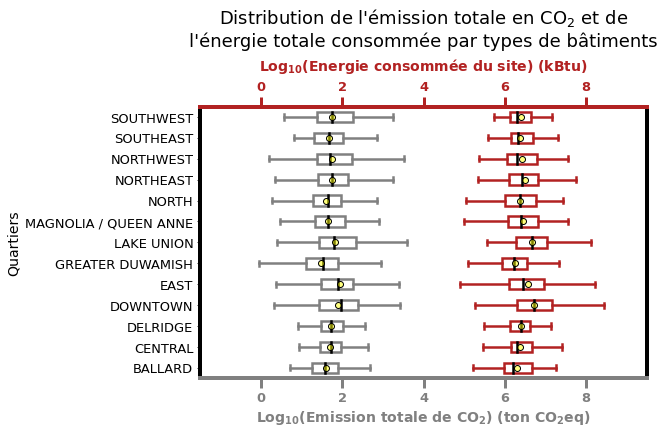

In [144]:
# Nous listons les différents quartiers.
liste_quart = sorted(building_no_house["Neighborhood"].unique())

# Nous créeons les listes des valeurs en émission de CO2 et en consommation d'énergie 
# pour les différents quartiers.

val_quart_co2 = []
val_quart_ener = []

for quart in liste_quart:
    val_quart_co2.append(np.log10(building_no_house.loc[(building_no_house["Neighborhood"]==quart) &
                                                        (building_no_house["TotalGHGEmissions"]>0),
                                                        "TotalGHGEmissions"].values))

    val_quart_ener.append(np.log10(building_no_house.loc[(building_no_house["Neighborhood"]==quart) &
                                                         (building_no_house["SiteEnergyUse(kBtu)"]>0),
                                                         "SiteEnergyUse(kBtu)"].values))    

    
# Nous traçons des boxplots pour chaque quartier en fonction de l'émission en CO2 et en 
# consommation d'énergie.

plt.figure(figsize=(8,5))    
plt.boxplot(val_quart_co2, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="gray",linewidth=2.5),
            boxprops=dict(facecolor="white", color="gray",linewidth=2.5),
            whiskerprops=dict(color="gray",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.gca().tick_params(axis="x", width=3, size=10, labelsize=13, labelcolor="gray", 
                      length=10, color="gray")
plt.xticks(weight="bold")


plt.yticks(np.arange(1,len(liste_quart)+1,1), liste_quart[:], fontsize=13)

plt.xlabel(r"$\bf{Log_{10}}$(Emission totale de $\bf{CO_{2}}$) (ton $\bf{CO_{2}}eq$)",  
           fontsize=14, color="gray", weight="bold")
plt.ylabel("Quartiers", fontsize=14)

plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)

plt.xlim(-1.5,9.5)

plt.twinx()
plt.twiny()

plt.boxplot(val_quart_ener, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="firebrick",linewidth=2.5),
            boxprops=dict(facecolor="white", color="firebrick",linewidth=2.5),
            whiskerprops=dict(color="firebrick",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.gca().spines['top'].set_color("firebrick")
plt.gca().spines['top'].set_linewidth(4)
plt.gca().spines['bottom'].set_color("gray")
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['right'].set_linewidth(4)
plt.gca().tick_params(axis="x", width=3, size=10, labelsize=13, labelcolor="firebrick", 
                      length=10, color="firebrick")

plt.xticks(weight="bold")
plt.yticks([])

plt.xlim(-1.5,9.5)

plt.xlabel(r"$\bf{Log_{10}}$(Energie consommée du site) (kBtu)", 
           fontsize=14, color="firebrick",labelpad=10, weight="bold")

plt.title(r"Distribution de l'émission totale en $\rmCO_{\rm2}$ et de" 
          "\nl'énergie totale consommée par types de bâtiments", 
          fontsize=18, pad=10)
plt.show()

In [145]:
# Nous créeons une fonction pour calculer la fonction eta² pour déterminer le coefficient de corrélation
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    if SCT!=0:
        return SCE/SCT
    else:
        return np.nan

# Nous importons la fonction f_oneway pour calculer la p-value
from scipy.stats import f_oneway

In [146]:
# Nous calculons eta² pour l'émission des gaz à effet de serre en fonction du quartier

eta_co2 = eta_squared(building_no_house["Neighborhood"], building_no_house["TotalGHGEmissions"])
display(f"La valeur de eta² est de {round(eta_co2,5)}.")

# Nous calculons la p-value en utilsant une boucle pour collecter chaque donnée par quartier

donnée_f =[]
for quart in liste_quart:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["Neighborhood"]==quart,"TotalGHGEmissions"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2], donnée_f[3], donnée_f[4], 
                             donnée_f[5], donnée_f[6], donnée_f[7], donnée_f[8], donnée_f[9], 
                             donnée_f[10], donnée_f[11], donnée_f[12]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.01714.'

'La p-value est de 0.00613.'

In [147]:
# Nous faisons la même chose que prédemment mais cette fois-ci en étudiant 
# la consommation d'énergie totale

eta_ener = eta_squared(building_no_house["Neighborhood"], building_no_house["SiteEnergyUse(kBtu)"])
display(f"La valeur de eta² est de {round(eta_ener,5)}.")

donnée_f =[]
for quart in liste_quart:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["Neighborhood"]==quart,"SiteEnergyUse(kBtu)"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2], donnée_f[3], donnée_f[4], 
                             donnée_f[5], donnée_f[6], donnée_f[7], donnée_f[8], donnée_f[9], 
                             donnée_f[10], donnée_f[11], donnée_f[12]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.0161.'

'La p-value est de 0.01075.'

Nous pouvons voir à travers une analyse graphique et mathématique qu'il n'y a pas de corrélation entre les quartiers et l'émission de gaz à effet de serre ainsi que la consommation totale d'énergie.
En revanche, les comportements de l'émission de gaz à effet de serre et de la consommation totale d'énergie sont similaires. Cette relation sera étudiée dans l'analyse bivariée.
Nous allons mener la même étude pour les quartiers "compacts", le types de bâtiments ainis que pour le type de propriétés. 

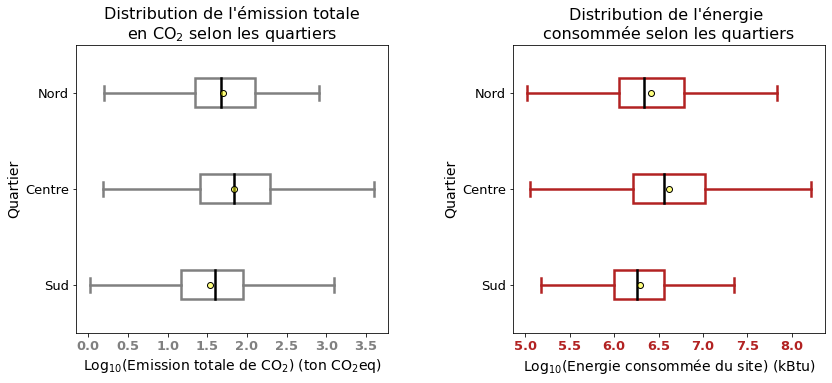

In [148]:
liste_quart_comp = ["Sud","Centre","Nord"]

val_quart_co2 = []
val_quart_ener = []

for quart in liste_quart_comp:
    val_quart_co2.append(np.log10(building_no_house.loc[(building_no_house["Quartier_compact"]==quart) & 
                                                        (building_no_house["TotalGHGEmissions"]>0),
                                                        "TotalGHGEmissions"].values))

    val_quart_ener.append(np.log10(building_no_house.loc[(building_no_house["Quartier_compact"]==quart) & 
                                                         (building_no_house["SiteEnergyUse(kBtu)"]>0),
                                                         "SiteEnergyUse(kBtu)"].values))    

plt.figure(figsize=(13,5))    
plt.subplot(121)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.boxplot(val_quart_co2, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="gray",linewidth=2.5),
            boxprops=dict(facecolor="white", color="gray",linewidth=2.5),
            whiskerprops=dict(color="gray",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.xticks(color = "gray", fontsize=13, weight="bold")
plt.yticks(np.arange(1,len(liste_quart_comp)+1,1), liste_quart_comp[:],fontsize=13)

plt.xlabel(r"$\rmLog_{\rm 10}$(Emission totale de $\rmCO_{\rm2}$) (ton $\rmCO_{\rm2}eq$)", fontsize=14)
plt.ylabel("Quartier", fontsize=14)

plt.title(r"Distribution de l'émission totale" "\n" r"en $\rmCO_{\rm2}$ selon les quartiers", 
          fontsize=16)

plt.subplot(122)

plt.boxplot(val_quart_ener, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="firebrick",linewidth=2.5),
            boxprops=dict(facecolor="white", color="firebrick",linewidth=2.5),
            whiskerprops=dict(color="firebrick",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.xticks(color = "firebrick", fontsize=13, weight="bold")
plt.yticks(np.arange(1,len(liste_quart_comp)+1,1), liste_quart_comp[:],fontsize=13)

plt.xlabel(r"$\rmLog_{\rm 10}$(Energie consommée du site) (kBtu)", fontsize=14)
plt.ylabel("Quartier", fontsize=14)

plt.title("Distribution de l'énergie \nconsommée selon les quartiers", fontsize=16)

plt.show()

In [149]:
# Nous étudions cette fois-ci s'il y a une corrélation entre l'émission des gaz à effet de serre 
# et les noms de quartiers compact

eta = eta_squared(building_no_house["Quartier_compact"], building_no_house["TotalGHGEmissions"])
display(f"La valeur de eta² est de {round(eta,5)}.")

donnée_f =[]
for quart in liste_quart_comp:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["Quartier_compact"]==quart, "TotalGHGEmissions"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.00436.'

'La p-value est de 0.02978.'

In [150]:
# Nous faisons la même chose que prédemment mais cette fois-ci en étudiant la consommation d'énergie
# totale

eta = eta_squared(building_no_house["Quartier_compact"], building_no_house["SiteEnergyUse(kBtu)"])
display(f"La valeur de eta² est de {round(eta,5)}.")

donnée_f =[]
for quart in liste_quart_comp:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["Quartier_compact"]==quart, "SiteEnergyUse(kBtu)"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.00643.'

'La p-value est de 0.00562.'

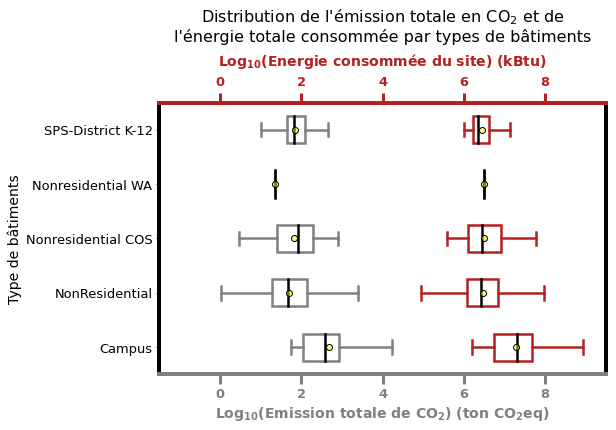

In [151]:
liste_build = sorted(building_no_house["BuildingType"].unique())

val_co2 = []
val_energie = []
for build in liste_build:
    val_co2.append(np.log10(building_no_house.loc[(building_no_house["BuildingType"]==build) & 
                                                    (building_no_house["TotalGHGEmissions"]>0),
                                                    "TotalGHGEmissions"].values))
    val_energie.append(np.log10(building_no_house.loc[(building_no_house["BuildingType"]==build) & 
                                                    (building_no_house["SiteEnergyUse(kBtu)"]>0),
                                                    "SiteEnergyUse(kBtu)"].values))

plt.figure(figsize=(8,5))    

plt.boxplot(val_co2, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="gray",linewidth=2.5),
            boxprops=dict(facecolor="white", color="gray",linewidth=2.5),
            whiskerprops=dict(color="gray",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.gca().tick_params(axis="x", width=3, size=10, labelsize=13, labelcolor="gray", 
                      length=10, color="gray")

plt.xticks(weight="bold")
plt.yticks(np.arange(1,len(liste_build)+1,1), liste_build[:], fontsize=13)

plt.xlabel(r"$\bf{Log_{10}}$(Emission totale de $\bf{CO_{2}}$) (ton $\bf{CO_{2}}eq$)",  
           fontsize=14, color="gray", weight="bold")
plt.ylabel("Type de bâtiments", fontsize=14)

plt.xlim(-1.5,9.5)

plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)

plt.twinx()
plt.twiny()

plt.boxplot(val_energie, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="firebrick",linewidth=2.5),
            boxprops=dict(facecolor="white", color="firebrick",linewidth=2.5),
            whiskerprops=dict(color="firebrick",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.gca().spines['top'].set_color("firebrick")
plt.gca().spines['top'].set_linewidth(4)
plt.gca().spines['bottom'].set_color("gray")
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['right'].set_linewidth(4)

plt.gca().tick_params(axis="x", width=3, size=10, labelsize=13, labelcolor="firebrick", 
                      length=10,color="firebrick")

plt.xticks(weight="bold")
plt.yticks([])

plt.xlim(-1.5,9.5)

plt.xlabel(r"$\bf{Log_{10}}$(Energie consommée du site) (kBtu)", fontsize=14, color="firebrick",
           labelpad=10, weight="bold")

plt.title(r"Distribution de l'émission totale en $\rmCO_{\rm2}$ et de" 
          "\nl'énergie totale consommée par types de bâtiments", 
          fontsize=16, pad=10)

plt.show()

In [152]:
# Nous étudions cette fois-ci s'il y a une corrélation entre l'émission des gaz à effet de serre 
# et les types de bâtiments

eta = eta_squared(building_no_house["BuildingType"], building_no_house["TotalGHGEmissions"])
display(f"La valeur de eta² est de {round(eta,5)}.")

donnée_f =[]
for build in liste_build:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["BuildingType"]==build,"TotalGHGEmissions"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2], donnée_f[3], donnée_f[4]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.07948.'

'La p-value est de 0.0.'

In [153]:
# Nous faisons la même chose que prédemment mais cette fois-ci en étudiant la consommation d'énergie totale

eta = eta_squared(building_no_house["BuildingType"], building_no_house["SiteEnergyUse(kBtu)"])
display(f"La valeur de eta² est de {round(eta,5)}.")

donnée_f =[]
for build in liste_build:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["BuildingType"]==build,"SiteEnergyUse(kBtu)"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2], donnée_f[3], donnée_f[4]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.09329.'

'La p-value est de 0.0.'

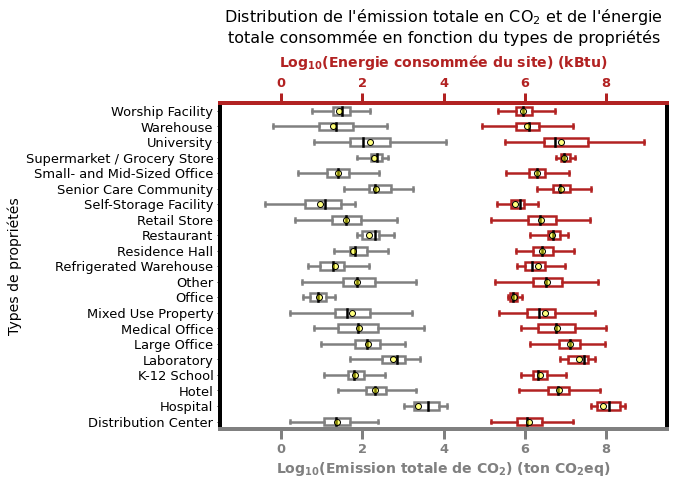

In [154]:
liste_prop = sorted(building_no_house["PrimaryPropertyType"].unique())

val_co2 = []
val_energie = []
for prop in liste_prop:
    val_co2.append(np.log10(building_no_house.loc[(building_no_house["PrimaryPropertyType"]==prop) & 
                                                  (building_no_house["TotalGHGEmissions"]>0), 
                                                  "TotalGHGEmissions"].values))
    val_energie.append(np.log10(building_no_house.loc[(building_no_house["PrimaryPropertyType"]==prop) & 
                                                      (building_no_house["SiteEnergyUse(kBtu)"]>0), 
                                                      "SiteEnergyUse(kBtu)"].values))

plt.figure(figsize=(8,6))    

plt.boxplot(val_co2, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="gray",linewidth=2.5),
            boxprops=dict(facecolor="white", color="gray",linewidth=2.5),
            whiskerprops=dict(color="gray",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.gca().tick_params(axis="x", width=3, size=10, labelsize=13, labelcolor="gray", 
                      length=10, color="gray")

plt.xticks(weight="bold")
plt.yticks(np.arange(1,len(liste_prop)+1,1), liste_prop[:], fontsize=13)

plt.xlabel(r"$\bf{Log_{10}}$(Emission totale de $\bf{CO_{2}}$) (ton $\bf{CO_{2}}eq$)",  
           fontsize=14, color="gray", weight="bold")
plt.ylabel("Types de propriétés", fontsize=14)

plt.xlim(-1.5,9.5)

plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)

plt.twinx()
plt.twiny()

plt.boxplot(val_energie, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="firebrick",linewidth=2.5),
            boxprops=dict(facecolor="white", color="firebrick",linewidth=2.5),
            whiskerprops=dict(color="firebrick",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.gca().spines['top'].set_color("firebrick")
plt.gca().spines['top'].set_linewidth(4)
plt.gca().spines['bottom'].set_color("gray")
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['right'].set_linewidth(4)

plt.gca().tick_params(axis="x", width=3, size=10, labelsize=13, labelcolor="firebrick", 
                      length=10,color="firebrick")

plt.xticks(weight="bold")
plt.yticks([])

plt.xlim(-1.5,9.5)

plt.xlabel(r"$\bf{Log_{10}}$(Energie consommée du site) (kBtu)", fontsize=14, color="firebrick",
           labelpad=10, weight="bold")

plt.title(r"Distribution de l'émission totale en $\rmCO_{\rm2}$" " et de l'énergie \ntotale consommée en fonction du types de propriétés", 
          fontsize=16, pad=10)

plt.show()

In [155]:
# Nous étudions cette fois-ci s'il y a une corrélation entre l'émission des gaz à effet de serre et les types de propriétés

eta = eta_squared(building_no_house["PrimaryPropertyType"], building_no_house["TotalGHGEmissions"])
display(f"La valeur de eta² est de {round(eta,5)}.")

donnée_f =[]
for prop in liste_prop:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["PrimaryPropertyType"]==prop,"TotalGHGEmissions"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2], donnée_f[3], donnée_f[4], donnée_f[5], donnée_f[6], 
                             donnée_f[7], donnée_f[8], donnée_f[9], donnée_f[10], donnée_f[11], donnée_f[12], donnée_f[13], 
                             donnée_f[14], donnée_f[15], donnée_f[16], donnée_f[17], donnée_f[18], donnée_f[19], 
                             donnée_f[20]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.29555.'

'La p-value est de 0.0.'

In [156]:
# Nous faisons la même chose que prédemment mais cette fois-ci en étudiant la consommation d'énergie totale
eta = eta_squared(building_no_house["PrimaryPropertyType"], building_no_house["SiteEnergyUse(kBtu)"])
display(f"La valeur de eta² est de {round(eta,5)}.")

donnée_f =[]
for prop in liste_prop:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["PrimaryPropertyType"]==prop,"SiteEnergyUse(kBtu)"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2], donnée_f[3], donnée_f[4], donnée_f[5], donnée_f[6], 
                             donnée_f[7], donnée_f[8], donnée_f[9], donnée_f[10], donnée_f[11], donnée_f[12], donnée_f[13], 
                             donnée_f[14], donnée_f[15], donnée_f[16], donnée_f[17], donnée_f[18], donnée_f[19], 
                             donnée_f[20]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.18577.'

'La p-value est de 0.0.'

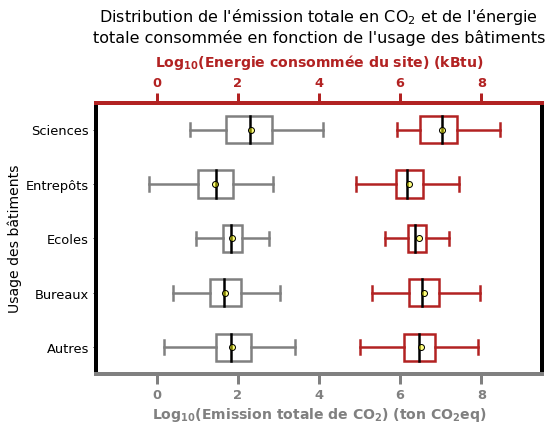

In [157]:
liste_prop_comp = sorted(building_no_house["Usage_bâtiments"].unique())

val_co2 = []
val_energie = []
for prop_comp in liste_prop_comp:
    val_co2.append(np.log10(building_no_house.loc[(building_no_house["Usage_bâtiments"]==prop_comp) & 
                                                  (building_no_house["TotalGHGEmissions"]>0),
                                                  "TotalGHGEmissions"].values))
    val_energie.append(np.log10(building_no_house.loc[(building_no_house["Usage_bâtiments"]==prop_comp) & 
                                                      (building_no_house["SiteEnergyUse(kBtu)"]>0),
                                                      "SiteEnergyUse(kBtu)"].values))

plt.figure(figsize=(8,5))    

plt.boxplot(val_co2, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="gray",linewidth=2.5),
            boxprops=dict(facecolor="white", color="gray",linewidth=2.5),
            whiskerprops=dict(color="gray",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.gca().tick_params(axis="x", width=3, size=10, labelsize=13, labelcolor="gray", 
                      length=10, color="gray")

plt.xticks(weight="bold")
plt.yticks(np.arange(1,len(liste_prop_comp)+1,1), liste_prop_comp[:], fontsize=13)

plt.xlabel(r"$\bf{Log_{10}}$(Emission totale de $\bf{CO_{2}}$) (ton $\bf{CO_{2}}eq$)",  
           fontsize=14, color="gray", weight="bold")
plt.ylabel("Usage des bâtiments", fontsize=14)

plt.xlim(-1.5,9.5)

plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)

plt.twinx()
plt.twiny()

plt.boxplot(val_energie, vert=False, showfliers=False, patch_artist=True, 
            capprops =dict(color="firebrick",linewidth=2.5),
            boxprops=dict(facecolor="white", color="firebrick",linewidth=2.5),
            whiskerprops=dict(color="firebrick",linewidth=2.5),
            medianprops=dict(color="black",linewidth=2.5),
            showmeans=True, 
            meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':(1, 1, 0, 0.5)})

plt.gca().spines['top'].set_color("firebrick")
plt.gca().spines['top'].set_linewidth(4)
plt.gca().spines['bottom'].set_color("gray")
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['right'].set_linewidth(4)

plt.gca().tick_params(axis="x", width=3, size=10, labelsize=13, labelcolor="firebrick", 
                      length=10,color="firebrick")

plt.xticks(weight="bold")
plt.yticks([])

plt.xlim(-1.5,9.5)

plt.xlabel(r"$\bf{Log_{10}}$(Energie consommée du site) (kBtu)", fontsize=14, color="firebrick",
           labelpad=10, weight="bold")

plt.title(r"Distribution de l'émission totale en $\rmCO_{\rm2}$" " et de l'énergie \ntotale consommée en fonction de l'usage des bâtiments", 
          fontsize=16, pad=10)

plt.show()

In [158]:
# Nous étudions cette fois-ci s'il y a une corrélation entre l'émission des gaz à effet de serre et 
# les types de propriétés renommées

eta = eta_squared(building_no_house["Usage_bâtiments"], building_no_house["TotalGHGEmissions"])
display(f"La valeur de eta² est de {round(eta,5)}.")

donnée_f =[]
for prop_comp in liste_prop_comp:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["Usage_bâtiments"]==prop_comp,"TotalGHGEmissions"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2], donnée_f[3], donnée_f[4]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.06224.'

'La p-value est de 0.0.'

In [159]:
# Nous faisons la même chose que prédemment mais cette fois-ci en étudiant la consommation d'énergie totale
eta = eta_squared(building_no_house["Usage_bâtiments"], building_no_house["SiteEnergyUse(kBtu)"])
display(f"La valeur de eta² est de {round(eta,5)}.")

donnée_f =[]
for prop_comp in liste_prop_comp:
    donnée_quart = []
    donnée_quart = building_no_house.loc[building_no_house["Usage_bâtiments"]==prop_comp,"SiteEnergyUse(kBtu)"]
    donnée_f.append(donnée_quart)

résultat_foneway = (f_oneway(donnée_f[0], donnée_f[1], donnée_f[2], donnée_f[3], donnée_f[4]))

display(f"La p-value est de {round(résultat_foneway[1],5)}.")

'La valeur de eta² est de 0.03181.'

'La p-value est de 0.0.'

Sur les différentes analyses menées, nous observons deux aspects redondants :
- il n'y a jamais de corrélation entre les variables catégorielles étudiées ici et l'émission de gaz à effet de serre ou la consommation totale d'énergie,
- les tendances entre la consommation totale d'énergie et l'émission de gaz à effet de serre sont très proches.

<a class="anchor" id="section_2_2"></a>
## Analyse bivariée
<a class="anchor" id="section_2_2_1"></a>
### Matrice de corrélation
Nous regardons à présent les possibles corrélations qui peuvent exister entre les différentes variables numériques. Pour cela, nous sélectionnons les variables numériques pertinentes puis nous déterminons la matrice de corrélation.

In [160]:
colonne_corr = building_no_house.select_dtypes(include='number').columns.tolist()
display(colonne_corr)

['OSEBuildingID',
 'DataYear',
 'ZipCode',
 'CouncilDistrictCode',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Nbr_activités',
 'Hauteur',
 'Surf_uni',
 'Surface',
 '%_occ_1st',
 '%_occ_2nd',
 '%_occ_3rd']

Certaines variables ont un attrait purement indicatif ('OSEBuildingID', 'DataYear', 'ZipCode', 'CouncilDistrictCode'). 

Nous pouvons voir que deux variables sont exprimées selon deux unités qui ne diffère que d'un facteur proportionnel ('Electricity(kWh)' et 'Electricity(kBtu)', 'NaturalGas(therms)' et 'NaturalGas(kBtu)'). Nous ne gardons que celles exprimées en kBtu. 

In [161]:
colonne_corr = ["YearBuilt", 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', "Hauteur", "Surf_uni", 
                "Nbr_activités", "PropertyGFATotal", 'PropertyGFABuilding(s)', "PropertyGFAParking", 
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'Surface', 
                '%_occ_1st', '%_occ_2nd', '%_occ_3rd', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 
                'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 
                'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

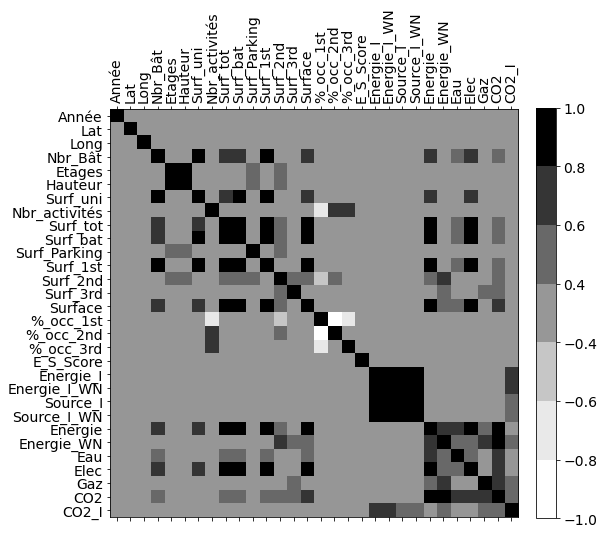

In [162]:
from matplotlib.colors import ListedColormap
matrix = building_no_house[colonne_corr].corr()

plt.figure(figsize=[8,8])

boundaries = [-1,-0.8,-0.6,-0.4, 0.4, 0.6,0.8, 1]
norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256, extend='neither')

colonne_simplifié = ["Année","Lat", "Long", 'Nbr_Bât', 'Etages', "Hauteur", "Surf_uni", "Nbr_activités", "Surf_tot", "Surf_bat",
                     "Surf_Parking", 'Surf_1st', 'Surf_2nd', 'Surf_3rd', 'Surface', '%_occ_1st', '%_occ_2nd', '%_occ_3rd',
                     'E_S_Score', "Energie_I", "Energie_I_WN", "Source_I", "Source_I_WN", 'Energie', 'Energie_WN', 'Eau',
                     'Elec','Gaz','CO2','CO2_I']
plt.matshow(matrix, norm=norm, cmap='Greys', fignum=1)
plt.xticks(range(len(colonne_simplifié)), colonne_simplifié, fontsize=14, rotation=90)
plt.yticks(range(len(colonne_simplifié)), colonne_simplifié, fontsize=14)
plt.colorbar(fraction=0.046, pad=0.04).ax.tick_params(labelsize=14)

plt.show()

Nous pouvons observer plusieurs fortes corrélations. Il y a des corrélations entre les surfaces de bâtiments et les surfaces principales car il y a une forte proportion de bâtiments qui n'ont qu'une utilisation principale. C'est pourquoi nous ne gardons que la surface totale.

Concernant les énergies et les sources, il y a plusieurs corrélations notamment entre les données mesurées et celles dans des conditions météorologiques moyennes ("SiteEUIWN(kBtu/sf)" et "SourceEUIWN(kBtu/sf)"). De plus, il y a une forte corrélation entre l'énergie alimentant un bâtiment ("SourceEUI") et celle consommée par le bâtiment ("SiteEUI") ce qui est attendu car pour pouvoir consommer de l'énergie il faut en recevoir. 

Certaines données ("SiteEUIWN(kBtu/sf)" & "SiteEnergyUse(kBtu)", "TotalGHGEmissions" & "GHGEmissionsIntensity") sont exprimées en intensité (kBtu/ft) ou en kBtu. Ce sont des variables qui ne diffèrent que par un facteur de proportionnalité qui est la surface totale. C'est pourquoi nous ne gardons que les données exprimées en kBtu.

Enfin, l'énergie est la somme de la consommation d'électricité, d'eau et de gaz naturels. C'est pourquoi nous allons ignorer ces variables.

Voici les différentes variables considérer pour l'étude bivariée : 
- "YearBuilt",
- "Latitude",
- "Longitude",
- "Hauteur", 
- "Surf_unit",
- "Nbr_activités",
- "PropertyGFATotal",
- "PropertyGFAParking",
- "%_occ_1st",
- "%_occ_2nd", 
- "%_occ_3rd",
- "ENERGYSTARScore",
- "SiteEnergyUse(kBtu)",
- "TotalGHGEmissions"

In [163]:
colonne_corr = ["YearBuilt", 'Latitude', 'Longitude', "Hauteur", "Surf_uni", "Nbr_activités", "PropertyGFATotal", 
                "PropertyGFAParking", '%_occ_1st', '%_occ_2nd', '%_occ_3rd', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 
                'TotalGHGEmissions']

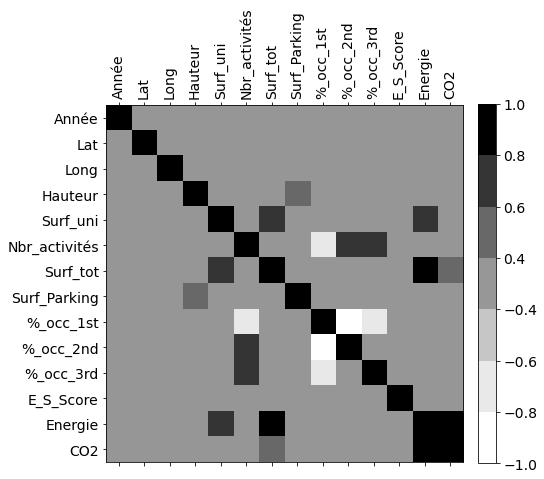

,YearBuilt,Latitude,Longitude,Hauteur,Surf_uni,Nbr_activités,PropertyGFATotal,PropertyGFAParking,%_occ_1st,%_occ_2nd,%_occ_3rd,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
YearBuilt,1.00,0.06,0.01,0.09,-0.05,0.06,0.09,0.28,-0.05,0.08,-0.07,-0.03,0.06,0.05
Latitude,0.06,1.00,-0.09,-0.01,0.02,-0.01,0.01,0.04,0.03,-0.02,-0.04,0.04,0.01,0.00
Longitude,0.01,-0.09,1.00,-0.02,0.02,-0.05,0.02,-0.03,0.06,-0.07,-0.01,0.00,0.03,0.04
Hauteur,0.09,-0.01,-0.02,1.00,-0.02,0.22,0.38,0.49,-0.09,0.10,0.02,0.11,0.19,0.09
Surf_uni,-0.05,0.02,0.02,-0.02,1.00,-0.02,0.77,-0.01,0.02,-0.02,-0.01,0.01,0.70,0.36
Nbr_activités,0.06,-0.01,-0.05,0.22,-0.02,1.00,0.14,0.24,-0.72,0.63,0.64,0.05,0.10,0.07
PropertyGFATotal,0.09,0.01,0.02,0.38,0.77,0.14,1.00,0.37,-0.07,0.08,0.02,0.13,0.81,0.53
PropertyGFAParking,0.28,0.04,-0.03,0.49,-0.01,0.24,0.37,1.00,-0.20,0.22,0.04,0.09,0.14,0.06
%_occ_1st,-0.05,0.03,0.06,-0.09,0.02,-0.72,-0.07,-0.20,1.00,-0.96,-0.63,-0.02,-0.07,-0.05
%_occ_2nd,0.08,-0.02,-0.07,0.10,-0.02,0.63,0.08,0.22,-0.96,1.00,0.40,0.03,0.06,0.04


In [164]:
matrix = building_no_house[colonne_corr].corr()

plt.figure(figsize=[7,7])

boundaries = [-1, -0.8, -0.6, -0.4, 0.4, 0.6, 0.8,  1]
norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256, extend='neither')

colonne_simplifié = ["Année", "Lat", "Long", "Hauteur", "Surf_uni", "Nbr_activités", "Surf_tot", "Surf_Parking", '%_occ_1st', 
                     '%_occ_2nd', '%_occ_3rd', 'E_S_Score', 'Energie', 'CO2']

plt.matshow(matrix, norm=norm, cmap='Greys', fignum=1)
plt.xticks(range(len(colonne_simplifié)), colonne_simplifié, fontsize=14, rotation=90)
plt.yticks(range(len(colonne_simplifié)), colonne_simplifié, fontsize=14)
plt.colorbar(fraction=0.046, pad=0.04).ax.tick_params(labelsize=14)
plt.show()
display(matrix.round(2))

Sur la nouvelle matrice des corrélations, nous voyons qu'il y a certaines corrélations notamment liées à la consommation totale d'énergie et l'émission des gaz à effet de serre. Nous allons uniquement étudier par le graphique la corrélation pouvant exister entre la consommation d'énergie ou l'émission de CO<sub>2</sub> et les autres variables.
<a class="anchor" id="section_2_2_2"></a>
### Consommation d'énergie totale

L'équation de régression linéaire s'écrit 0.84x. Le coefficient R² vaut 0.496


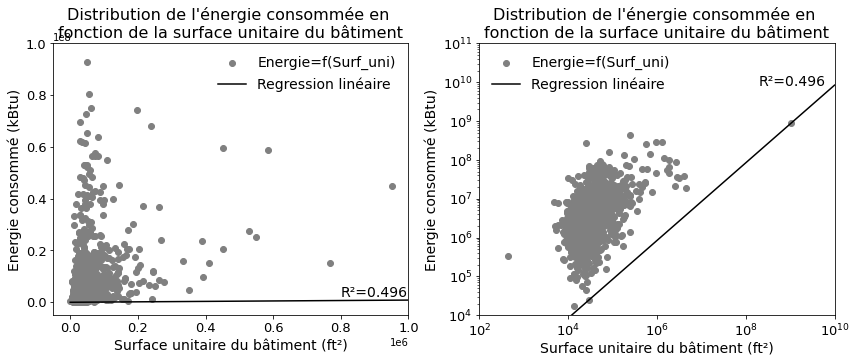

In [165]:
# Régression linéaire
X = building_no_house[["Surf_uni"]]
Y = building_no_house["SiteEnergyUse(kBtu)"]

X = X.copy() 

result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a = result.params['Surf_uni']
r_2 = (st.pearsonr(building_no_house["Surf_uni"],Y)[0])**2
print(f"L'équation de régression linéaire s'écrit {round(a,2)}x. Le coefficient R² vaut {round(r_2,3)}")

# Traçé du graphique et de la courbe de tendance

plt.figure(figsize=(14,5))

plt.subplot(121)

plt.scatter(building_no_house["Surf_uni"], Y, color="gray", label = "Energie=f(Surf_uni)")
reg = np.linspace(0,1e6)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xlabel("Surface unitaire du bâtiment (ft²)", fontsize=14)
plt.ylabel("Energie consommé (kBtu)", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlim(-5e4,1e6)
plt.ylim(-5e6,1e8)

plt.legend(fontsize=14, loc=1).get_frame().set_edgecolor("white")

plt.text(0.8e6,2e6, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title("Distribution de l'énergie consommée en \nfonction de la surface unitaire du bâtiment", fontsize=16)

plt.subplot(122)

plt.scatter(building_no_house["Surf_uni"], Y, color="gray", label = "Energie=f(Surf_uni)")
reg = np.linspace(-1e9,1e10)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Surface unitaire du bâtiment (ft²)", fontsize=14)
plt.ylabel("Energie consommé (kBtu)", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(1e2,1e10)
plt.ylim(1e4,1e11)

plt.legend(fontsize=14, loc=2).get_frame().set_edgecolor("white")

plt.text(2e8,8e9, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title("Distribution de l'énergie consommée en \nfonction de la surface unitaire du bâtiment", fontsize=16)
plt.show()

L'équation de régression linéaire s'écrit 82.27x. Le coefficient R² vaut 0.661


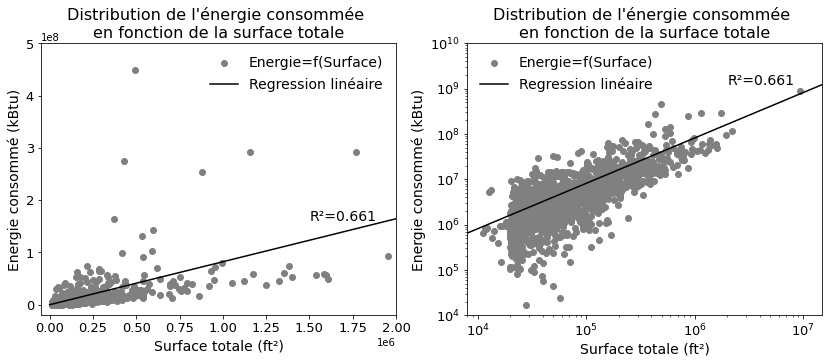

In [166]:
# Régression linéaire

X = building_no_house[["PropertyGFATotal"]]
Y = building_no_house["SiteEnergyUse(kBtu)"]

X = X.copy()

result = sm.OLS(Y, X).fit() 
a = result.params['PropertyGFATotal']
r_2= (st.pearsonr(building_no_house["PropertyGFATotal"],Y)[0])**2
print(f"L'équation de régression linéaire s'écrit {round(a,2)}x. Le coefficient R² vaut {round(r_2,3)}")

# Traçé du graphique et de la courbe de tendance

plt.figure(figsize=(14,5))
plt.subplot(121)

plt.scatter(building_no_house["PropertyGFATotal"], Y, color="gray", label = "Energie=f(Surface)")
reg = np.linspace(0,1e7)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xlabel("Surface totale (ft²)", fontsize=14)
plt.ylabel("Energie consommé (kBtu)", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlim(-5e4,2e6)
plt.ylim(-2e7,5e8)

plt.legend(fontsize=14).get_frame().set_edgecolor("white")

plt.text(1.5e6,1.6e8, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title("Distribution de l'énergie consommée \nen fonction de la surface totale", fontsize=16)

plt.subplot(122)

plt.scatter(building_no_house["PropertyGFATotal"], Y, color="gray", label = "Energie=f(Surface)")
reg = np.linspace(-1e10,1e8)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Surface totale (ft²)", fontsize=14)
plt.ylabel("Energie consommé (kBtu)", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlim(8e3,1.5e7)
plt.ylim(1e4,1e10)

plt.legend(frameon=False, loc=2, fontsize=14)

plt.text(2e6,1.2e9, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title("Distribution de l'énergie consommée \nen fonction de la surface totale", fontsize=16)
plt.show()

Lorsque nous traçons la distribution de l'énergie consommée en fonction de la surface, nous voyons que plus la surface est grande, plus l'énergie consommée est grande. 
Cela est tout à fait attendu dans la mesure où plus un bâtiment est grand, plus il y a de personnes ou d'appareils présents pour y travailler ou l'entretenir et plus les besoins en énergie sont grands.

L'équation de régression linéaire s'écrit 2.1e-05x. Le coefficient R² vaut 0.739


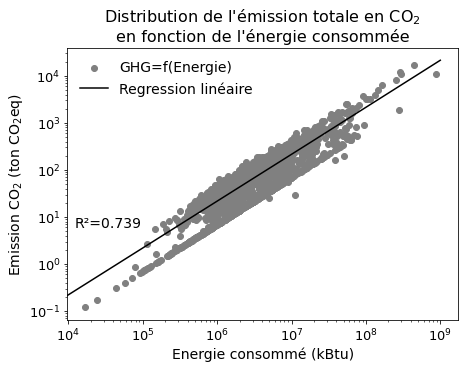

In [167]:
# Régression linéaire
X = building_no_house[["SiteEnergyUse(kBtu)"]]
Y = building_no_house["TotalGHGEmissions"]

X = X.copy() 

result = sm.OLS(Y, X).fit() 
a = result.params['SiteEnergyUse(kBtu)']
r_2 = (st.pearsonr(building_no_house["SiteEnergyUse(kBtu)"],Y)[0])**2
print(f"L'équation de régression linéaire s'écrit {round(a,6)}x. Le coefficient R² vaut {round(r_2,3)}")

# Traçé du graphique et de la courbe de tendance

plt.figure(figsize=(7,5))

plt.scatter(building_no_house["SiteEnergyUse(kBtu)"], Y, color="gray", label = "GHG=f(Energie)")
plt.plot(np.linspace(-1e6,1e9),[(a*x) for x in np.linspace(-1e6,1e9)], color="black", label="Regression linéaire")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energie consommé (kBtu)", fontsize=14)
plt.ylabel(r"Emission $\rmCO_{\rm2}$ (ton $\rmCO_{\rm2}eq$)", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=14,loc=2).get_frame().set_edgecolor("white")

plt.text(1.2e4,6, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title(r"Distribution de l'émission totale en $\rmCO_{\rm2}$" "\nen fonction de l'énergie consommée", fontsize=16)

plt.show()

Nous venons de traçer la distribution de l'émission en CO<sub>2</sub> en fonction de l'énergie consommée.
Comme nous l'avons précedemment observé, il y a une réelle corrélation entre ces deux variables : plus l'énergie consommée augmente, plus l'émission totale de CO<sub>2</sub> augmente.

<a class="anchor" id="section_2_2_3"></a>
### Emission de CO<sub>2</sub>
Nous allons analyser l'émission totale de CO<sub>2</sub> en fonction de la surface totale.

L'équation de régression linéaire s'écrit 0.00139x. Le coefficient R² vaut 0.281


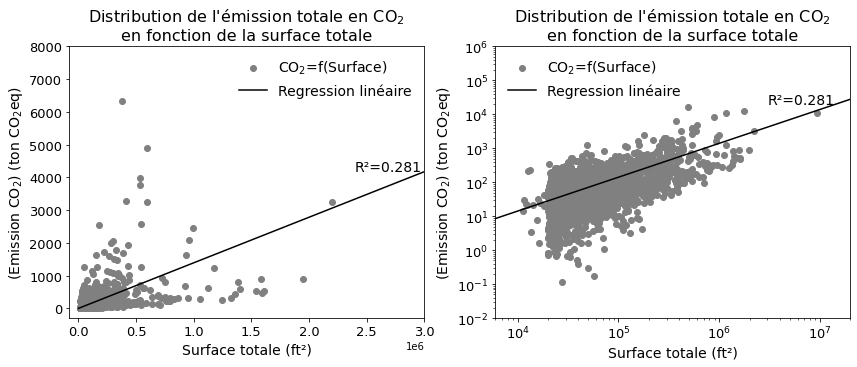

In [168]:
# Régression linéaire

X = building_no_house[["PropertyGFATotal"]]
Y = building_no_house["TotalGHGEmissions"]

X = X.copy()
result = sm.OLS(Y, X).fit() 
a = result.params['PropertyGFATotal']
r_2 = (st.pearsonr(building_no_house["PropertyGFATotal"],Y)[0])**2
print(f"L'équation de régression linéaire s'écrit {round(a,5)}x. Le coefficient R² vaut {round(r_2,3)}")

# Traçé du graphique et de la courbe de tendance

plt.figure(figsize=(14,5))
plt.subplot(121)

plt.scatter(building_no_house["PropertyGFATotal"], Y, color="gray", label = r"$\rmCO_{\rm2}$=f(Surface)")
reg = np.linspace(0,1e7)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xlabel("Surface totale (ft²)", fontsize=14)
plt.ylabel(r"(Emission $\rmCO_{\rm2}$) (ton $\rmCO_{\rm2}eq$)", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlim(-8e4,3e6)
plt.ylim(-3e2,8e3)
plt.legend(fontsize=14).get_frame().set_edgecolor("white")

plt.text(2.4e6,4.2e3, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title(r"Distribution de l'émission totale en $\rmCO_{\rm2}$" "\nen fonction de la surface totale", fontsize=16)

plt.subplot(122)

plt.scatter(building_no_house["PropertyGFATotal"], Y, color="gray", label = r"$\rmCO_{\rm2}$=f(Surface)")
reg = np.linspace(-1e10,3e7)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Surface totale (ft²)", fontsize=14)
plt.ylabel(r"(Emission $\rmCO_{\rm2}$) (ton $\rmCO_{\rm2}eq$)", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlim(6e3,2e7)
plt.ylim(1e-2,1e6)

plt.legend(frameon=False, loc=2, fontsize=14)

plt.text(3e6,2e4, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title(r"Distribution de l'émission totale en $\rmCO_{\rm2}$" "\nen fonction de la surface totale", fontsize=16)
plt.show()

Nous venons de traçer la distribution de l'émission de GHG en fonction de la surface totale d'un bâtiment et il n'y a pas vraiment de corrélation entre ces deux variables.

<a class="anchor" id="section_2_3"></a>
## Analyse multivariée
<a class="anchor" id="section_2_3_1"></a>
### Préparation des données et fonctions

Nous venons d'avoir un aperçu des possibles corrélations entre variables. Nous allons analyser les variables numériques du jeu de données via une analyse en composante principale. Avant cela, nous allons créer les fonctions nécéssaires à cette analyse multivariée. 

In [169]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x, y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(7, 7))
    
    couleurs = ["limegreen", "royalblue", "black", "magenta", "deepskyblue", "forestgreen", "goldenrod", "crimson",
                "grey"]*2

    style_lignes = ["solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", 
                   "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted"]
    
    
    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                 pca.components_[x, i],  
                 pca.components_[y, i],  
                 head_width=0.04,
                 head_length=0.04, 
                 #width=0.007,
                 linewidth=3,
                 color = couleurs[i],
                 ls = style_lignes[i])

        # Les labels
        if (pca.components_[x, i]>=0) & (pca.components_[y, i]>=0) & i//2:
            plt.text(pca.components_[x, i] + 0.05,
                     pca.components_[y, i] - (0.03-i*0.003),
                     features[i],
                     color = couleurs[i],
                     fontsize=10,
                     weight="bold",
                     horizontalalignment="left")

        elif (pca.components_[x, i]>=0) & (pca.components_[y, i]>=0) & ~i//2:
            plt.text(pca.components_[x, i] + (0.03-i*0.001),
                     pca.components_[y, i] + (0.03+i*0.003),
                     features[i],
                     color = couleurs[i],
                     fontsize=10,
                     weight="bold",
                     horizontalalignment="right")
        
        elif (pca.components_[x, i]>=0) & (pca.components_[y, i]<0) & i//2:
            plt.text(pca.components_[x, i] + (0.03*1/(i+1)),
                     pca.components_[y, i] - (0.03+i*0.006),
                     features[i],
                     color = couleurs[i],
                     fontsize=10,
                     weight="bold")
        elif (pca.components_[x, i]>=0) & (pca.components_[y, i]<0) & ~i//2:
            plt.text(pca.components_[x, i] + (0.09),
                     pca.components_[y, i] - (0.04+i*0.001),
                     features[i],
                     color = couleurs[i],
                     fontsize=10,
                     weight="bold")
            
        elif (pca.components_[x, i]<0) & (pca.components_[y, i]>=0):
            plt.text(pca.components_[x, i]-0.05,
                     pca.components_[y, i],
                     features[i],
                     color = couleurs[i],
                     fontsize=10,
                     weight="bold",
                     horizontalalignment="right")
        elif (pca.components_[x, i]<0) & (pca.components_[y, i]<0):
            plt.text(pca.components_[x, i] - 0.05,
                     pca.components_[y, i] - 0.05,
                     features[i],
                     color = couleurs[i],
                     fontsize=10,
                     weight="bold",
                     horizontalalignment="right")
    
    custom_lines = []
    
    for i in range (0,pca.components_.shape[1],1):
        custom_lines.append(Line2D([0], [0], color=couleurs[i], linestyle=style_lignes[i], lw=4))
       
 
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({} %)'.format(x+1, round(100*pca.explained_variance_ratio_[x])),fontsize = 16)
    plt.ylabel('F{} ({} %)'.format(y+1, round(100*pca.explained_variance_ratio_[y])),fontsize = 16)


    # Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1), fontsize = 18)

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an), c="black")  # Add a unit circle for scale

    # Axes et affichage
    plt.axis('scaled')
    plt.legend(custom_lines, features, frameon=False, bbox_to_anchor=(1, 1), fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show(block=False)

In [170]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[7,7], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque 
    composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,7)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1,figsize=(7,6))

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    plt.scatter(   X_[:, x], 
                        X_[:, y], 
                        alpha=alpha, 
                        c="grey", 
                        cmap="Set1", 
                        marker=marker)


    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} ({v1})', fontsize = 16)
    ax.set_ylabel(f'F{y+1} ({v2})', fontsize = 16)

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1
    
    # Pourcentage de valeurs dans chaque quart (Nord-Est, Sud-Est, Nord-Ouest et Sud-Ouest) de la projection
    n_e = np.where(((X_projected[:,x])>0) & ((X_projected[:,y])>0))
    n_e_list = list(chain.from_iterable(n_e))

    s_e = np.where(((X_projected[:,x])>0) & ((X_projected[:,y])<0))
    s_e_list = list(chain.from_iterable(s_e))

    n_o = np.where(((X_projected[:,x])<0) & ((X_projected[:,y])>0))
    n_o_list = list(chain.from_iterable(n_o))

    s_o = np.where(((X_projected[:,x])<0) & ((X_projected[:,y])<0))
    s_o_list = list(chain.from_iterable(s_o))

    n_n = np.where(((X_projected[:,x])==0) | ((X_projected[:,y])==0))
    n_n_list = list(chain.from_iterable(n_n))
    
    
    nbr_n_e = round(len(n_e_list)*100/len(X_projected),1)
    nbr_s_e = round(len(s_e_list)*100/len(X_projected),1)
    nbr_n_o = round(len(n_o_list)*100/len(X_projected),1)
    nbr_s_o = round(len(s_o_list)*100/len(X_projected),1)
    
    # Affichage de ces pourcentages dans leurs quarts respectifs 
    plt.text(0.75*x_max, 0.9*y_max, f"{round(nbr_n_e,3)}%", color ="firebrick", fontsize=14)
    plt.text(0.75*x_max, -0.95*y_max, f"{round(nbr_s_e,3)}%", color ="firebrick", fontsize=14)
    plt.text(-0.95*x_max, 0.9*y_max, f"{round(nbr_n_o,3)}%", color ="firebrick", fontsize=14)
    plt.text(-0.95*x_max, -0.95*y_max, f"{round(nbr_s_o,3)}%", color ="firebrick", fontsize=14)

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})", fontsize = 18)
    plt.show()

Nous allons maintenant sélectionner les mêmes colonnes que dans l'analyse bivariée car ce sont les plus pertinentes pour l'étude. Nous retirons cependant la variable "ENERGYSTARScore car nous avons des données manquantes 

In [171]:
building_no_house = building_no_house.rename(columns = {"YearBuilt" : "Année",
                                                        "NumberofBuildings" : "N_Bat",
                                                        'NumberofFloors': "N_Floor",
                                                        "PropertyGFATotal" : "Surf_tot",
                                                        "PropertyGFABuilding(s)" : "Surf_bât",
                                                        'PropertyGFAParking': "Surf_Park",
                                                        'LargestPropertyUseTypeGFA' : "Surf_1st",
                                                        'SecondLargestPropertyUseTypeGFA': "Surf_2nd",
                                                        'ThirdLargestPropertyUseTypeGFA': "Surf_3rd",
                                                        "SiteEUI(kBtu/sf)": "Energie_I",
                                                        "SourceEUI(kBtu/sf)" : "Source_E_I",
                                                        'SiteEnergyUse(kBtu)': "Energie",
                                                        'TotalGHGEmissions': "CO2",
                                                        "GHGEmissionsIntensity" : "CO2_I"})
colonne = ["Année", "Latitude", "Longitude", "Nbr_activités", "Hauteur", "Surf_uni", "Surf_tot", "Surf_Park", "%_occ_1st", 
           "%_occ_2nd", "%_occ_3rd",  "Energie","CO2"]

In [172]:
display(building_no_house.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610 entries, 0 to 1611
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1610 non-null   int64  
 1   DataYear                       1610 non-null   int64  
 2   BuildingType                   1610 non-null   object 
 3   PrimaryPropertyType            1610 non-null   object 
 4   PropertyName                   1610 non-null   object 
 5   Address                        1610 non-null   object 
 6   City                           1610 non-null   object 
 7   State                          1610 non-null   object 
 8   ZipCode                        1594 non-null   float64
 9   TaxParcelIdentificationNumber  1610 non-null   object 
 10  CouncilDistrictCode            1610 non-null   int64  
 11  Neighborhood                   1610 non-null   object 
 12  Latitude                       1610 non-null   f

None

<a class="anchor" id="section_2_3_2"></a>
### Analyse en Composante Principale (ACP)
<a class="anchor" id="section_2_3_2_1"></a>
### Données bruts
Nous allons commencer l'analyse en composante principale en utilisant les données que nous venons de nettoyer.

array([26.45, 21.92, 11.84,  8.37,  7.54,  6.72,  5.61,  4.85,  3.51,
        2.23,  0.7 ,  0.26,  0.  ])

array([ 26.,  48.,  60.,  69.,  76.,  83.,  88.,  93.,  97.,  99., 100.,
       100., 100.])

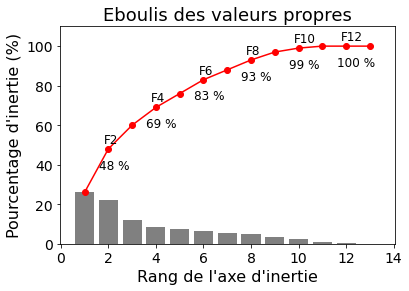

In [173]:
X = building_no_house[colonne].values
names = building_no_house[colonne].index
features = colonne
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

n_components = building_no_house[colonne].shape[1]
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)

plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Eboulis des valeurs propres", fontsize=18)

plt.ylim(0,110)

for a,b in zip(x_list[1::2], scree_cum[1::2]): 
    plt.text(a-0.4, b-10, f"{int(b)} %",fontsize=12)
    plt.text(a-0.2, b+3, f"F{int(a)}",fontsize=12)

plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
#display(pcs.round(2))

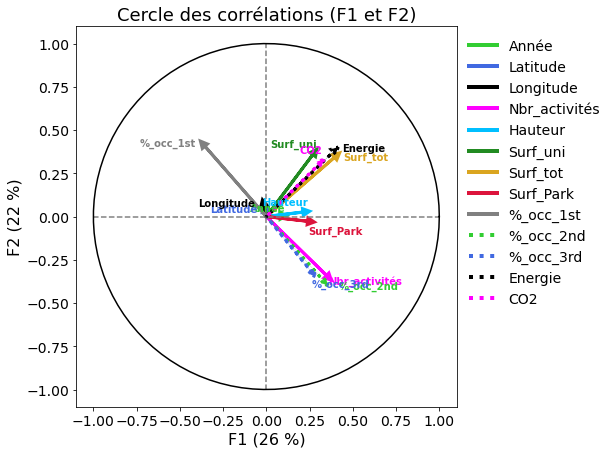

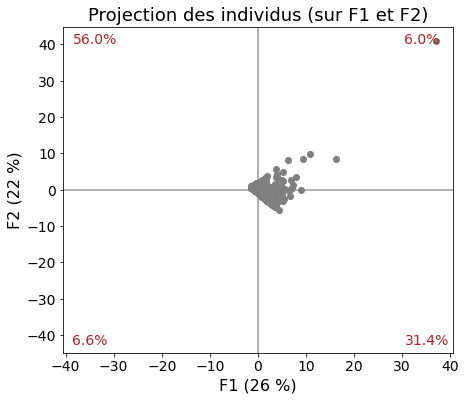

In [174]:
x_y = [0,1]
X_proj = pca.transform(X_scaled)

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

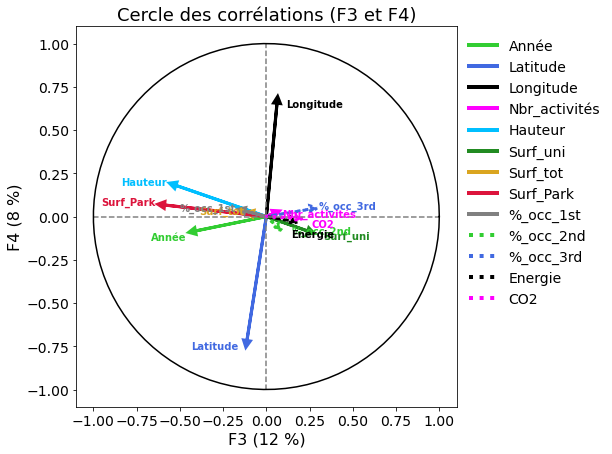

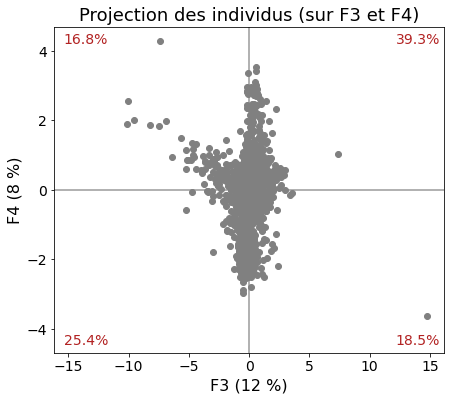

In [175]:
x_y = [2,3]
X_proj = pca.transform(X_scaled)

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

<a class="anchor" id="section_2_3_2_2"></a>
### Filtres successifs
Nous observons qu'il y a plusieurs valeurs extrêmes. Nous les supprimons car ces valeurs apportent trop de poids aux composantes.

In [176]:
cp_1 = np.where(np.abs(X_proj[:,0])>=20)
cp_1_list = list(chain.from_iterable(cp_1))

cp_2 = np.where(np.abs(X_proj[:,1])>=20)
cp_2_list = list(chain.from_iterable(cp_2))

cp_3 = np.where((X_proj[:,2])>=5)
cp_3_list = list(chain.from_iterable(cp_3))

cp_4 = np.where(np.abs(X_proj[:,3])>=4)
cp_4_list = list(chain.from_iterable(cp_4))


liste_ = cp_1_list + cp_2_list + cp_3_list + cp_4_list

result = [] 
for i in liste_: 
    if i not in result: 
        result.append(i) 

indexes_to_keep = set(range(building_no_house.shape[0])) - set(result)
building_no_house_sliced = building_no_house.take(list(indexes_to_keep))
display(building_no_house_sliced.shape)
X_proj =[]

(1607, 53)

array([27.3 , 20.07, 11.24,  8.41,  7.75,  6.83,  6.05,  4.95,  3.23,
        2.2 ,  1.36,  0.62,  0.  ])

array([ 27.,  47.,  59.,  67.,  75.,  82.,  88.,  93.,  96.,  98.,  99.,
       100., 100.])

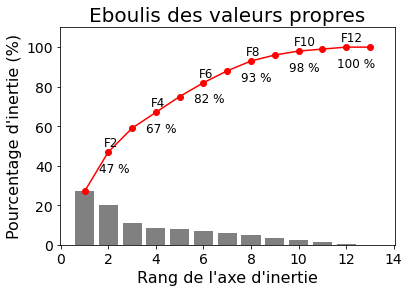

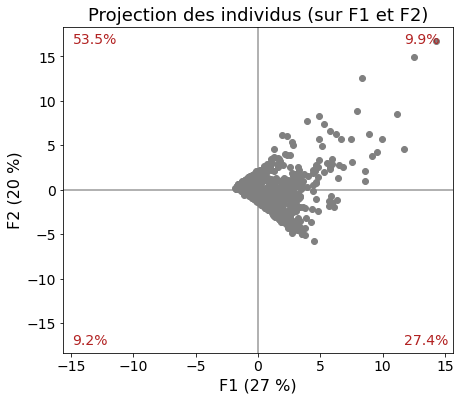

In [177]:
X = building_no_house_sliced[colonne].values
names = building_no_house_sliced[colonne].index
features = colonne
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

n_components = building_no_house_sliced[colonne].shape[1]
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)
plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Eboulis des valeurs propres", fontsize=20)
plt.ylim(0,110)
for a,b in zip(x_list[1::2], scree_cum[1::2]): 
    plt.text(a-0.4, b-10, f"{int(b)} %",fontsize=12)
    plt.text(a-0.2, b+3, f"F{int(a)}",fontsize=12)

plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
#display(pcs.round(2))

x_y = [0,1]
X_proj = pca.transform(X_scaled)

#correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

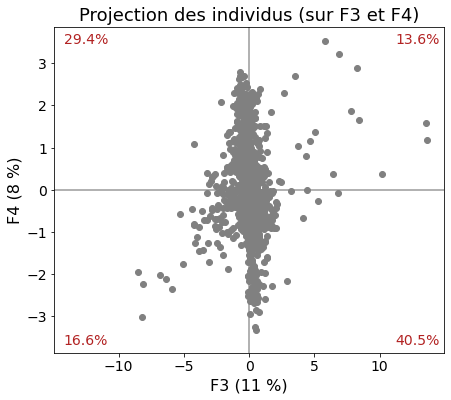

In [178]:
x_y = [2,3]
X_proj = pca.transform(X_scaled)

#correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

In [179]:
cp_1 = np.where(X_proj[:,0]>=13)
cp_1_list = list(chain.from_iterable(cp_1))

cp_2 = np.where(np.abs(X_proj[:,0])>=10)
cp_2_list = list(chain.from_iterable(cp_2))

cp_3 = np.where(np.abs(X_proj[:,2])>=10)
cp_3_list = list(chain.from_iterable(cp_3))

cp_4 = np.where(np.abs(X_proj[:,3])>=3)
cp_4_list = list(chain.from_iterable(cp_4))


liste_ = cp_1_list + cp_2_list + cp_3_list + cp_4_list

result = [] 
for i in liste_: 
    if i not in result: 
        result.append(i) 

indexes_to_keep = set(range(building_no_house_sliced.shape[0])) - set(result)
building_no_house_final = building_no_house_sliced.take(list(indexes_to_keep))


display(building_no_house_final.shape)
X_proj =[]

(1598, 53)

<a class="anchor" id="section_2_3_2_3"></a>
### Données finales

Nous venons d'effectuer plusieurs nettoyage afin de retirer des valeurs extrêmes. Nous allons pouvoir analyser le cercle des corrélations ainsi que la projection des individus.

array([27.78, 19.78, 10.1 ,  8.23,  7.95,  6.9 ,  6.05,  4.94,  3.44,
        2.2 ,  1.58,  1.05,  0.  ])

array([ 28.,  48.,  58.,  66.,  74.,  81.,  87.,  92.,  95.,  97.,  99.,
       100., 100.])

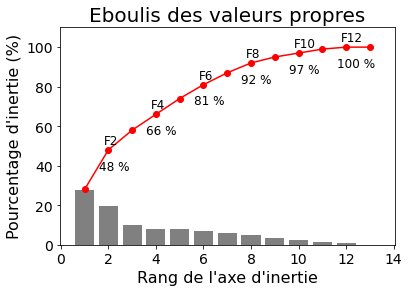

In [180]:
X = building_no_house_final[colonne].values
names = building_no_house_final[colonne].index
features = colonne
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

n_components = building_no_house_final[colonne].shape[1]
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display((scree))
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)
plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Eboulis des valeurs propres", fontsize=20)
plt.ylim(0,110)
for a,b in zip(x_list[1::2], scree_cum[1::2]): 
    plt.text(a-0.4, b-10, f"{int(b)} %",fontsize=12)
    plt.text(a-0.2, b+3, f"F{int(a)}",fontsize=12)
plt.ylim(0,110)
plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
#display(pcs.round(2))

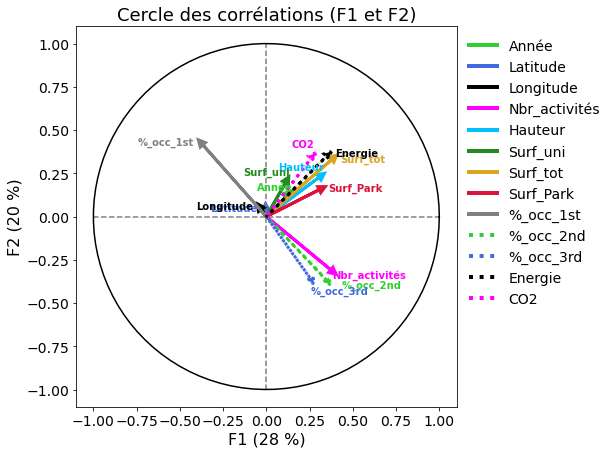

In [181]:
x_y = [0,1]
X_proj = pca.transform(X_scaled)

correlation_graph(pca, x_y, features)

Nous observons sur le cercle des corrélations que le nombre d'usage des bâtiments, la surface totale, l'énergie consommée, la surface occupée par les parkings sont corrélées à l'axe F1. De plus, il y a une anticorrélation entre l'axe F1 et le pourcentage d'occupation principale. 
Nous pouvons associer cet axe à un axe qui décrit la consommation d'énergie, des caractéristiques de surface et le nombre de leurs activités.

Nous observons une corrélation entre le pourcentage d'occupation principale, l'émission en CO<sub>2</sub> et l'énergie consommée. 
En revanche, il y a une anti-corrélation entre le pourcentage d'occupation secondaire, tertiaire et le nombre d'usage avec l'axe F2.

Nous pourrions associer l'axe F2 à un axe décrivant le nombre d'activités et leur pourcentage d'occupation dans un bâtiment, la consommation d'énergie et l'émission de CO<sub>2</sub>. 

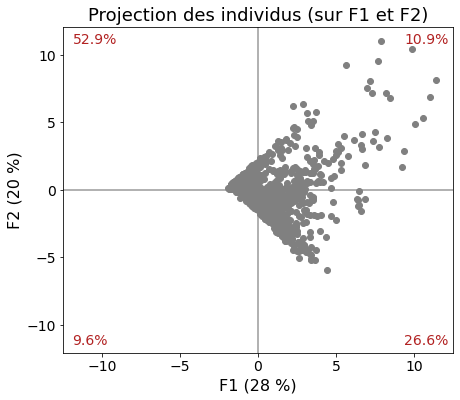

In [182]:
display_factorial_planes(X_proj, x_y, pca, marker="o")

Sur le graphique des projections des individus, le quart nord-est (10,9 % des données) représente les bâtiments volumineux, énergivores et pollueurs.

Le quart sud-est (26,5 % des données) représente les bâtiments ayant plusieurs activités et dont leur occupation en surface est non négligeable.

Dans le quart nord-ouest où il y a la majorité des données (52,9 %), nous retrouvons des bâtiments ayant majoritairement une activité principale occupant une très grande partie de la surface du bâtiment.

Enfin, dans le quart sud-ouest (9,7 % des données) nous avons les bâtiments peu énergivores, peu pollueurs et peu volumineux.

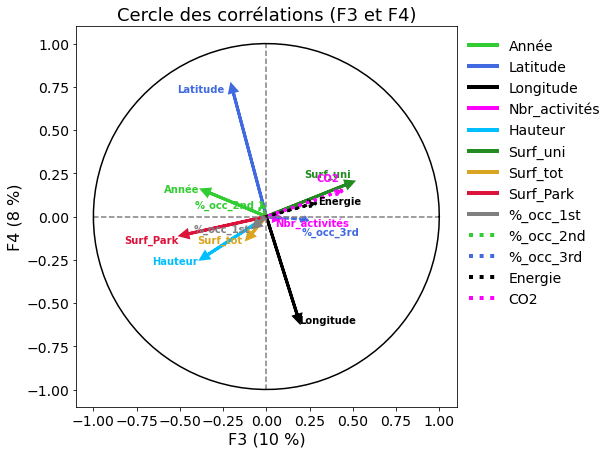

In [183]:
x_y = [2,3]
X_proj = pca.transform(X_scaled)

correlation_graph(pca, x_y, features)

Nous observons sur le cercle des corrélations que la surface unitaire et l'émission en CO<sub>2</sub> sont corrélée à l'axe F3. De plus, il y a une anti-corrélation entre l'axe F3 et la surface du parking des bâtiments, la hauteur des bâtiments ainsi que l'année de construction. 
Cet axe décrit donc des données structurelles des bâtiments, leur année de construction et leur émission de CO<sub>2</sub>.

Nous observons une très forte corrélation entre la latitude où se trouve les bâtiments avec l'axe F4. En revanche, la longitude est anti-corrélée à l'axe F4. 
L'axe F4 peut être associé à la localisation des bâtiments.

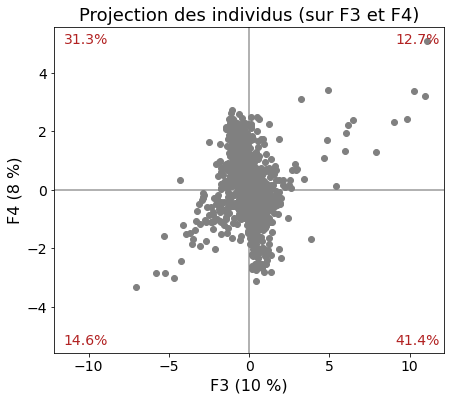

In [184]:
display_factorial_planes(X_proj, x_y, pca, marker="o")

Sur le graphique des projections des individus, le quart nord-est (12,5 % des données) représente les bâtiments large mais petit, sans parking, énergivore et polluant l'atmosphère. 

Le quart sud-est (41,8 % des données) représente les vieux bâtiments se trouvant au sud-est de Seattle

A l'inverse, nous retrouvons dans le quart nord-ouest (31,2 % des données) les sites les plus récents se trouvant au nord-ouest.

Enfin, dans le quart sud-ouest (14,6 % des données), nous avons les bâtiments les plus hauts et les moins larges, ayant un grand parking, peu énergivores et peu polluant pour l'atmosphère.

Nous allons regarder le nombre de bâtiments perdus après avoir appliqué autant de filtres durant l'analyse mutlivariée.

In [185]:
final = (building_no_house_final.shape[0])
initial = (building_no_house.shape[0])
perte = (initial - final)
print(f"Nous avons supprimé {perte} bâtiments. Cela représente {round(perte*100/initial,2)} % de pertes")

Nous avons supprimé 12 bâtiments. Cela représente 0.75 % de pertes


Nous avons perdu très peu de données. Nous allons sélectionner les variables que nous allons utiliser pour la modélisation et exporter les données sous forme de fichier csv.

In [186]:
display(building_no_house_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598 entries, 0 to 1611
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1598 non-null   int64  
 1   DataYear                       1598 non-null   int64  
 2   BuildingType                   1598 non-null   object 
 3   PrimaryPropertyType            1598 non-null   object 
 4   PropertyName                   1598 non-null   object 
 5   Address                        1598 non-null   object 
 6   City                           1598 non-null   object 
 7   State                          1598 non-null   object 
 8   ZipCode                        1582 non-null   float64
 9   TaxParcelIdentificationNumber  1598 non-null   object 
 10  CouncilDistrictCode            1598 non-null   int64  
 11  Neighborhood                   1598 non-null   object 
 12  Latitude                       1598 non-null   f

None

In [187]:
data = building_no_house_final[["Année", "Latitude", "Longitude", "Hauteur", "Surf_uni", "Nbr_activités", "Surf_tot", 
                                "Surf_Park", '%_occ_1st', '%_occ_2nd', '%_occ_3rd', 'ENERGYSTARScore','BuildingType', 
                                "ComplianceStatus", "Source_energie", 'Quartier_compact', 'Usage_bâtiments', 'CO2', 
                                'Energie']].reset_index()
data = data.drop(columns="index")
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Année             1598 non-null   int64  
 1   Latitude          1598 non-null   float64
 2   Longitude         1598 non-null   float64
 3   Hauteur           1598 non-null   float64
 4   Surf_uni          1598 non-null   float64
 5   Nbr_activités     1598 non-null   int64  
 6   Surf_tot          1598 non-null   int64  
 7   Surf_Park         1598 non-null   int64  
 8   %_occ_1st         1598 non-null   float64
 9   %_occ_2nd         1598 non-null   float64
 10  %_occ_3rd         1598 non-null   float64
 11  ENERGYSTARScore   1070 non-null   float64
 12  BuildingType      1598 non-null   object 
 13  ComplianceStatus  1598 non-null   object 
 14  Source_energie    1598 non-null   object 
 15  Quartier_compact  1598 non-null   object 
 16  Usage_bâtiments   1598 non-null   object 


None

In [188]:
data.to_csv('C:/Users/farid/Documents/Notebook/data_batiments_projet_4.csv')